# Partie 5: réalisation de l'ACP sur $\mathbb{R}^p$

## 5.1 Introduction

Pour réliser l'ACP, on utilise nos fonctions utilisés dans le TP ACP. Avec **PYTHON**, On essaie premièrement d'importer nos données "**train**" et "**test**" utilisés dans R à partie de la séparation avec un seed de 1234 pour pouvoir plus tard analyser et comparer les anomalies obtenus de l'ACP avec ceux de l'Isolation Forest.

Pour la question de standardisation des données ou non, notre premier reflexe sera d'utiliser des données centrés car comme on a vu dans le TP ACP: l'ACP standardisé conduit à une mise à l'échelle (scaling) des composantes principales et des variances éxpliqués par chaque points, ce qui est indésirable pour nous dans cette situation car on a besoin de bien distinguer les variances expliqués par chaque point dans chaque composante pour pouvoir visualiser plus tard l'effet des outliers sur la variance. Après si dans les données centrés l'ecart de variance est très grand entre les composantes, la distinction deviendra abberante et dans ce cas l'adoption de l'ACP standardisé est plus convenable.


On experimentera dans la suite avec les deux approches et on choisit la plus convenable.

On commence par importer les librairies nécessaires dans la suite.

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb

*On* importe puis on visualise nos données train et test.

In [260]:
# Importation des données train :
data_train = pd.read_excel('train_data.xlsx', decimal=',')
data_train.head()

,Income_Inequality,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
0,L,43044.997120,32416.819912,43757.013606,64,100.00000,42.0,2.7,1.7500,0.665518,1.258443e+06,1.202421,3.391014,0.794753,2.181061,0.151155,9.228086,0.498563,13.08,7.12404
1,H,58207.578310,49278.816384,62495.418887,76,100.00000,89.6,6.6,1.7655,0.915723,6.694028e+07,1.000000,3.738714,1.000000,1.549218,11.175388,14.823245,0.427546,0.00,5.10922
2,H,21452.921520,25778.473448,40041.105564,34,100.00000,85.0,8.5,2.0530,0.452552,2.227306e+05,0.442042,2.264699,1.038013,0.451604,0.000000,21.394807,20.462117,20.30,3.19000
3,H,5701.674149,8746.013481,11436.344113,43,91.09951,67.0,18.3,2.4870,0.300588,9.182161e+05,0.606352,2.715935,0.547731,-0.187987,32.137705,1.617522,9.999279,39.73,2.92276
4,L,12024.609507,21280.180517,25957.547446,57,100.00000,154.0,5.0,1.3200,0.451241,2.394525e+06,0.560190,3.327214,0.865860,0.768318,14.084801,7.516889,3.157677,18.09,4.93554


In [261]:
data_train.shape

(609, 20)

In [262]:
# Importation des données test :
data_test = pd.read_excel('test_data.xlsx', decimal=',')
data_test.head()

,Income_Inequality,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
0,H,3118.343699,4013.387617,6584.963632,5,37.131321,145.0,104.9,6.039,0.132618,1057144.125,0.671585,1.431295,0.414552,-0.990930,53.875463,0.947583,34.731008,36.60,3.08191
1,H,3185.122401,5360.889146,7766.977359,9,32.000000,145.0,92.9,5.864,0.133924,1162079.125,0.622806,1.445598,0.449489,-1.055084,54.933176,1.091497,22.124248,34.53,3.12292
2,H,3100.830685,5508.138454,7991.803167,15,42.000000,145.0,88.3,5.774,0.147570,1145485.375,0.426284,1.452803,0.416866,-0.893183,56.056403,1.125185,13.305675,35.25,3.48690
3,H,2914.415459,5285.425544,7088.190165,16,41.813129,145.0,84.4,5.686,0.154190,1092634.500,0.243273,1.460044,0.417792,-0.936142,56.904924,1.012552,20.885120,0.00,2.75494
4,H,2808.521753,5462.176989,7059.195320,16,43.013260,121.0,81.1,5.600,0.148656,1281953.250,0.316407,1.467321,0.414517,-0.919977,58.013752,0.829723,25.950330,0.00,2.46688


In [263]:
data_test.shape

(261, 20)

On essaie d'encoder "H"->0 et "L"->1 pour Income_Inequality, la variable à classifier pour chaqu'un des données train et test.

In [264]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(data_train["Income_Inequality"])
y_test = le.fit_transform(data_test["Income_Inequality"])
del data_train["Income_Inequality"]
del data_test["Income_Inequality"]

In [265]:
np.unique(y_train)

array([0, 1])

In [266]:
X= data_train.values
X.shape

(609, 19)

## 5.2 Application de l'ACP sur les données de la matrice X

On commence par un rappel des fonctions utilisées dans le TP ACP.

In [267]:
#Rappel des fonction statistiques:
def moyenne(X):
    n,_=np.shape(X)
    a=np.ones((n,n))
    return (1/n)*np.dot(a,X)

def cov(X):
    n,_=np.shape(X)
    a=X-moyenne(X)
    b=np.dot(np.transpose(a),a)
    return (1/(n))*b

def variance(X):
    return np.diag(cov(X))
def sigma(X):
    return np.sqrt(variance(X))

def corr(X):
    D=np.diag(1/sigma(X))
    a=cov(X)
    s=np.dot(a,D)
    s=np.dot(D,s)
    return s

# Centrage :
def center(X):
    return X-moyenne(X)

#Centrer et normer
def cennor(X):
    D = np.diag(1/sigma(X))
    return np.dot(center(X),D)

Rappel de la fonction de détermination des hyperplans pour lesquels l’inertie projetée est maximale.

In [268]:
def sorted_eig_val_vect(A) :
    eigenvalues , eigenvectors = np.linalg.eig(A)
    s = sorted ( eigenvalues , reverse = True )
    s=np.array(s)
    sorted_indices = np . argsort ( eigenvalues ) [:: -1]
    sorted_eigenvectors = eigenvectors [:,sorted_indices ]
    return s , sorted_eigenvectors

def hyperplans(X):
    A = cov(X)
    return sorted_eig_val_vect(A)

In [269]:
center(X).shape

(609, 19)

In [270]:
print("min :", np.min(center(X),axis=0))
print("max :", np.max(center(X),axis=0))
print()
center(X)

min : [-1.59595428e+04 -1.48536396e+04 -2.09602960e+04 -5.00870279e+01
 -8.04571635e+01 -7.92956486e+01 -2.39252874e+01 -1.68629228e+00
 -3.52806927e-01 -4.93771396e+06 -4.27979647e-01 -1.55500274e+00
 -4.74883866e-01 -1.84665440e+00 -2.59825003e+01 -5.09237802e+00
 -5.22468231e+00 -1.48288342e+01 -4.08420953e+00]
max : [7.08939804e+04 3.36671886e+04 7.04376674e+04 3.89129721e+01
 1.42428363e+01 1.95704351e+02 1.21774713e+02 4.88070772e+00
 5.73978915e-01 9.45126521e+07 1.01898817e+00 1.16919322e+00
 7.48862598e-01 2.01591732e+00 5.79780802e+01 3.44550018e+01
 3.69827888e+01 3.96611658e+01 5.30924526e+00]



array([[ 2.68153170e+04,  1.68051921e+04,  2.19491005e+04, ...,
        -4.73530223e+00, -1.74883415e+00,  2.57344690e+00],
       [ 4.19778982e+04,  3.36671886e+04,  4.06875057e+04, ...,
        -4.80631924e+00, -1.48288342e+01,  5.58626801e-01],
       [ 5.22324143e+03,  1.01668456e+04,  1.82331924e+04, ...,
         1.52282510e+01,  5.47116585e+00, -1.36059317e+00],
       ...,
       [ 5.57828695e+04,  2.06362277e+04,  7.04376674e+04, ...,
         2.68295246e+01, -2.67883415e+00, -4.76753086e-01],
       [-6.40598619e+03,  4.17084486e+02, -1.65353168e+03, ...,
         1.67488312e+01,  1.70911658e+01, -6.48903221e-01],
       [-2.15817140e+03,  2.31775143e+03, -6.21116958e+02, ...,
        -2.07827826e+00,  6.74116585e+00,  8.86016995e-01]])

D'après la visualisation des données, il est pertinent de standariser vu qu'il y a des nombre très grands pour des individus et d'autre non ce qui peut influencer l'ACP.
Si on doute quand même appliquons l'ACP au données centrées

In [271]:
Vpc,Vc = hyperplans(center(X))
Vpn,Vn = hyperplans(cennor(X))

On visualise les composantes principales pour les données centrés.

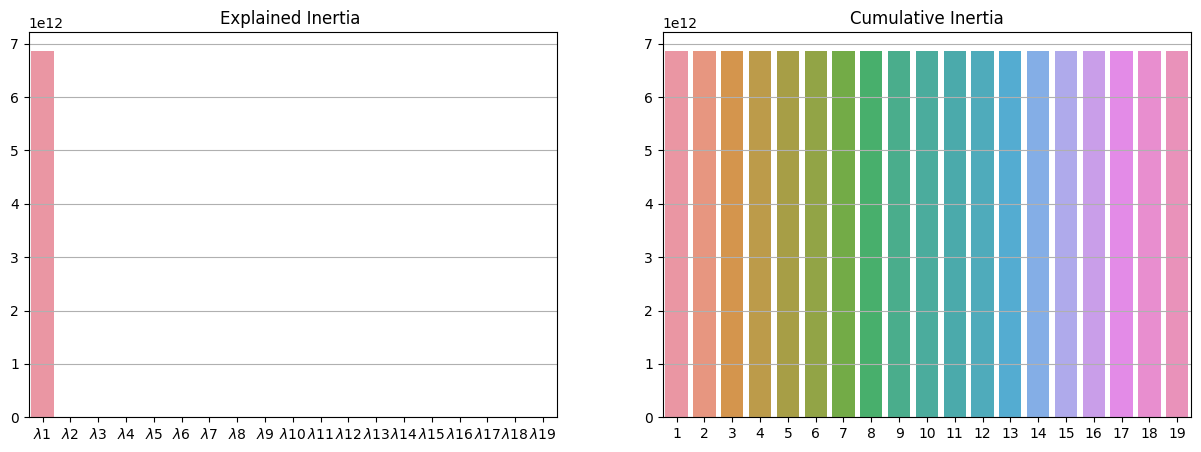

In [272]:
# Cas des données centrées
n = len(Vpc)
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Explained Inertia ")
ax2.set_title("Cumulative Inertia")
ax1.grid()
ax2.grid()
a = sum(Vpn)
# Create a bar plot for explained inertia :
x = [f'$\lambda${i}' for i in range(1, n + 1)]
y = [Vpc[i] / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax1)
# Create a bar plot for cumulative explained inertia
x = [f'{i}' for i in range(1, n + 1)]
y = [sum(Vpc[:i + 1]) / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax2)

plt.show()


Notre observation était donc juste, on voit qu'une seule composante qui est significative alos que cela peut être faux.

Dans la suite on travaillera avec les données standarisées (normalisées).

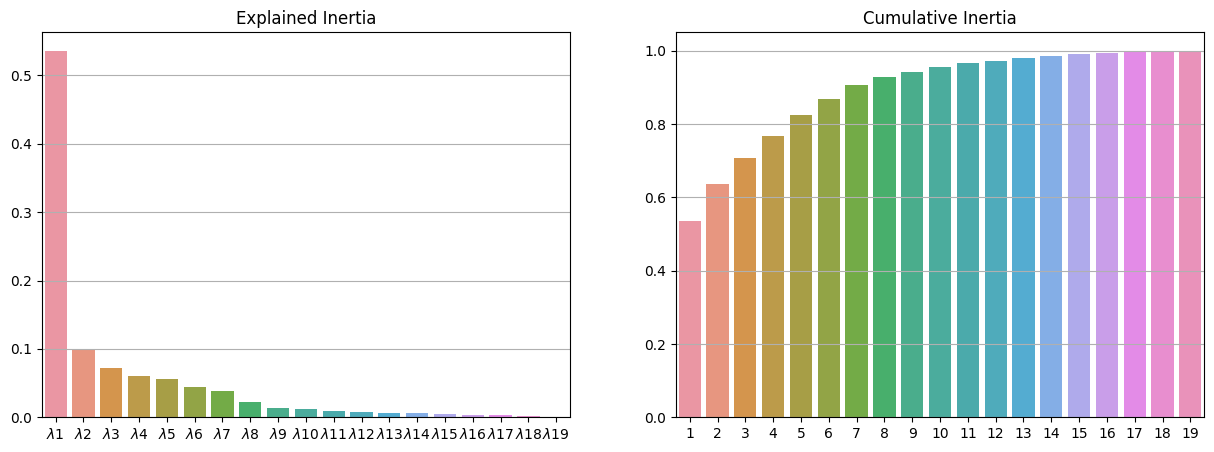

In [273]:
# Cas des données normalisées
n = len(Vpn)
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Explained Inertia")
ax2.set_title("Cumulative Inertia")
ax1.grid()
ax2.grid()
a = sum(Vpn)
# Create a bar plot for explained inertia :
x = [f'$\lambda${i}' for i in range(1, n + 1)]
y = [Vpn[i] / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax1)
# Create a bar plot for cumulative explained inertia :
x = [f'{i}' for i in range(1, n + 1)]
y = [sum(Vpn[:i + 1]) / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax2)

plt.show()

Ici, l'écart d'inertie entre les composantes principales est plus distinguable.

In [274]:
# On travaillera avec les données standarisées
X= cennor(X)
Vp,V = hyperplans(X)

règles de choix du nombre de composantes principales: Pour la règle de Cantell, on se limitera à une détection visuelle des cassures

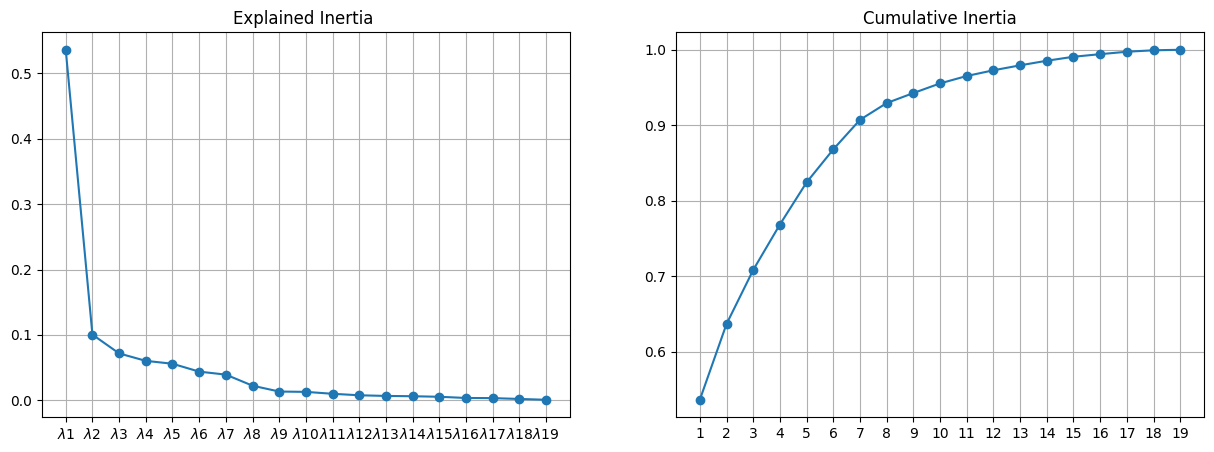

In [275]:
# Règle de Cantell
# Cas des données centrées
n = len(Vp)
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Explained Inertia ")
ax2.set_title("Cumulative Inertia")
ax1.grid()
ax2.grid()
a = sum(Vp)
# Create a plot for explained inertia :
x = [f'$\lambda${i}' for i in range(1, n + 1)]
y = [Vp[i]/a for i in range(n)]
ax1.plot(x,y,marker='o')
# Create a bar plot for cumulative explained inertia
x = [f'{i}' for i in range(1, n + 1)]
y = [sum(Vp[:i + 1]) / a for i in range(n)]
ax2.plot(x,y,marker='o')
print()
plt.show()

On peut dire que K=7, vu qu'on peut voir d'un coude apparent à gauche et un autre partagé avec la cummulative inertia plot. Mais cette visualisation reste tout de même imprécise.

In [276]:
# Règle de Karlis - Saporta - Spinaki
def K_S_S(X):
    n,p=np.shape(X)
    Z=hyperplans(X)[0]
    a=2*np.sqrt((p-1)/(n-1))
    return len(Z[Z>a])

print(K_S_S(X))

8


In [277]:
#Règle de Kaiser-Guttman : (Règle convenable quand on travaille avec des données normalisées)
def K_G(X):
    Z = hyperplans(X)[0]
    a = Z[Z >= 1]
    return len(a)

print(K_G(X))

5


On pose alors K=5

## 5.3 ACP sur les 5 premières composantes

Trouvons l'inertie totale et cummulée expliquée par les composantes.

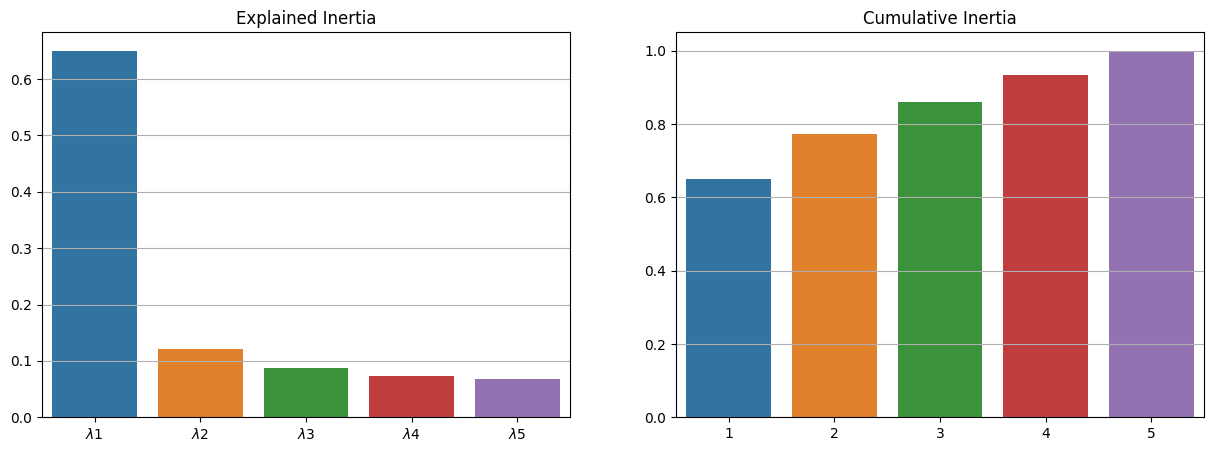

In [278]:
n = 5
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Explained Inertia")
ax2.set_title("Cumulative Inertia")
ax1.grid()
ax2.grid()
a = sum(Vpn[:5])
# Create a bar plot for explained inertia :
x = [f'$\lambda${i}' for i in range(1, n + 1)]
y = [Vpn[i] / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax1)
# Create a bar plot for cumulative explained inertia :
x = [f'{i}' for i in range(1, n + 1)]
y = [sum(Vpn[:i + 1]) / a for i in range(n)]
sb.barplot(x=x, y=y, ax=ax2)

plt.show()

Rappellons la fonction de projection :


In [279]:
def projection(X,k):
    P = hyperplans(X)[1]
    # We project onto the space of dimension k and then dimension p
    projection_k = np.dot(X, P[:,:k])
    full_projection = np.dot(X, P)
    return projection_k, full_projection

In [280]:
Z1 = projection(X,5)[0]
Z1.shape

(609, 5)

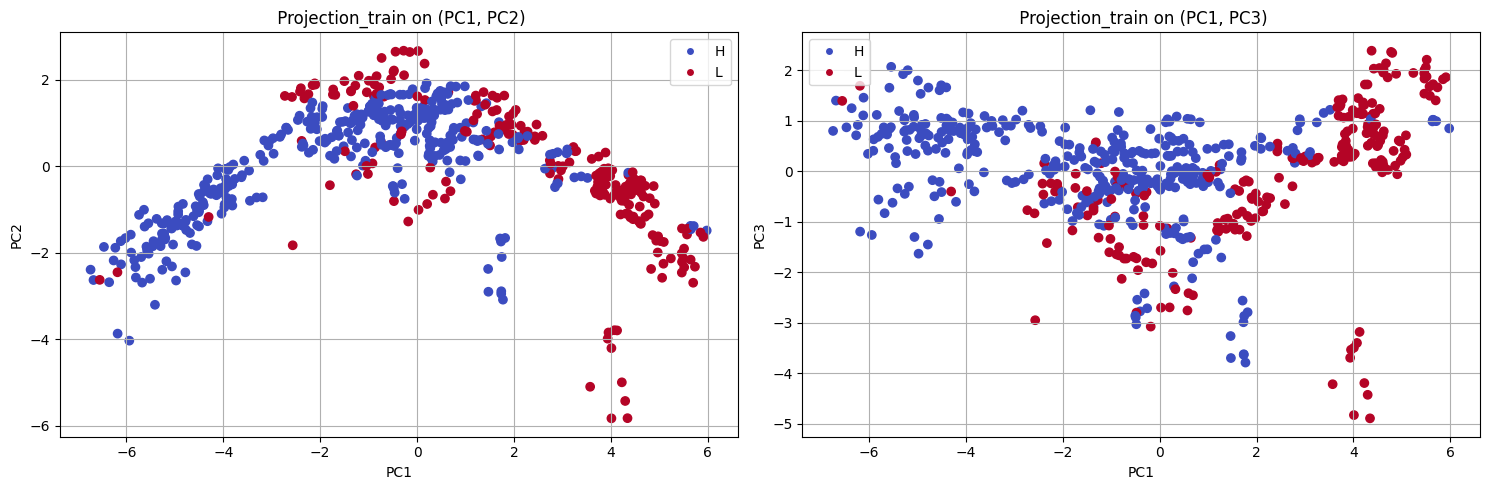

In [281]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Create subplots for centered data with CP1, CP2

ax1.set_title(' Projection_train on (PC1, PC2)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
scatter1=ax1.scatter(Z1[:, 0], Z1[:, 1],c=y_train, cmap='coolwarm')

ax1.grid()

# Create subplots for centered data with CP1, CP3

ax2.set_title(' Projection_train on (PC1, PC3)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.scatter(Z1[:, 0], Z1[:, 2],c=y_train, cmap='coolwarm')

ax2.grid()
t=['H','L']
# Create a color map legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=t[i],
                          markerfacecolor=scatter1.cmap(scatter1.norm(i)))
                   for i in np.unique(y_train)]
ax1.legend(handles=legend_elements)
ax2.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

Bien que les deux composantes principales expliquent plus de 60% de l'inertie, on a pas réussi à séparer totalement les deux classes.

On essaie ainsi de projeter les données test sur les composantes principales.

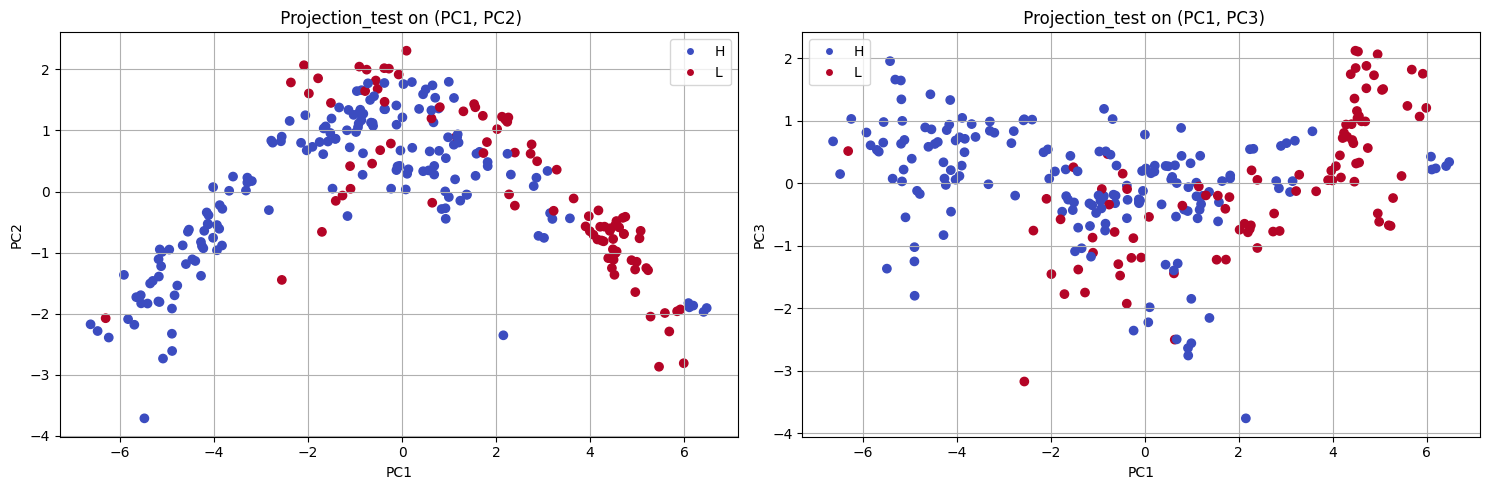

In [282]:
Y=data_test.values
Y=cennor(Y)
Z2=np.dot(Y,V[:,:5])

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Create subplots for centered data with CP1, CP2

ax1.set_title(' Projection_test on (PC1, PC2)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.scatter(Z2[:, 0], Z2[:, 1],c=y_test, cmap='coolwarm')

ax1.grid()

# Create subplots for centered data with CP1, CP3

ax2.set_title(' Projection_test on (PC1, PC3)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.scatter(Z2[:, 0], Z2[:, 2],c=y_test, cmap='coolwarm')

ax2.grid()
t=['H','L']
# Create a color map legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=t[i],
                          markerfacecolor=scatter1.cmap(scatter1.norm(i)))
                   for i in np.unique(y_test)]
ax1.legend(handles=legend_elements)
ax2.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

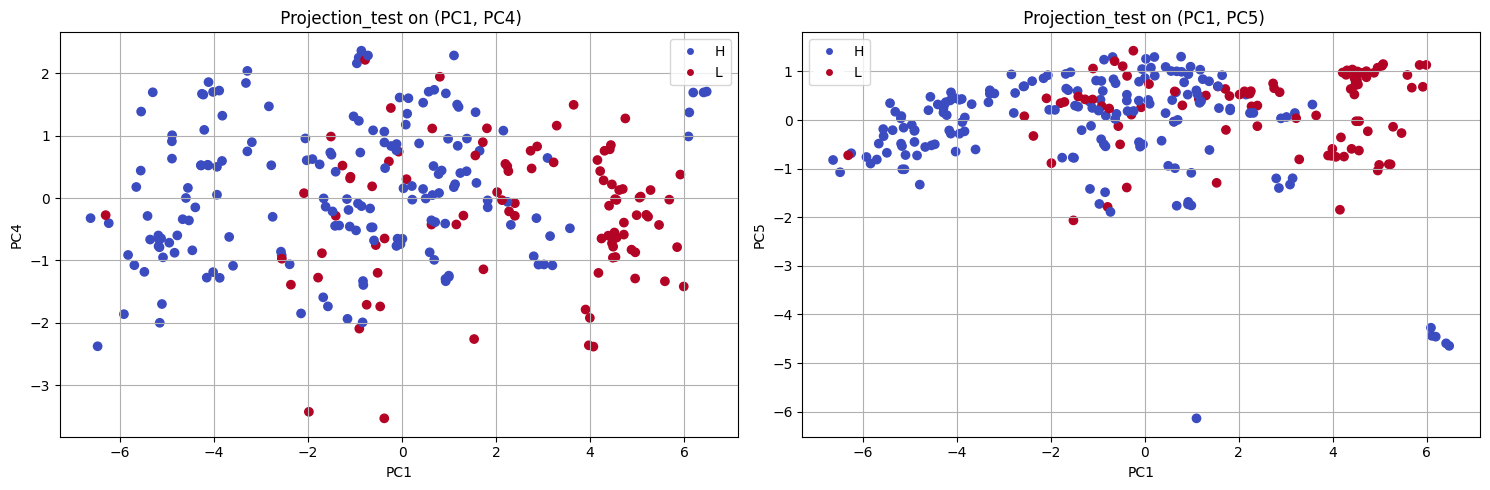

In [283]:

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title(' Projection_test on (PC1, PC4)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC4')
scatter1 = ax1.scatter(Z2[:, 0], Z2[:, 3], c=y_test, cmap='coolwarm')

ax1.grid()

ax2.set_title(' Projection_test on (PC1, PC5)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC5')
scatter2 = ax2.scatter(Z2[:, 0], Z2[:, 4],c=y_test, cmap='coolwarm')
ax2.grid()
t=['H','L']
# Create a color map legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=t[i],
                          markerfacecolor=scatter1.cmap(scatter1.norm(i)))
                   for i in np.unique(y_test)]
ax1.legend(handles=legend_elements)
ax2.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


On constate que le nuage des points ici est plus dispersé sur (PC1, PC4), cependant les deux classes ne sont pas encore bien séparés.

Essayons de visualiser les qualités de projections des données test standarisés.

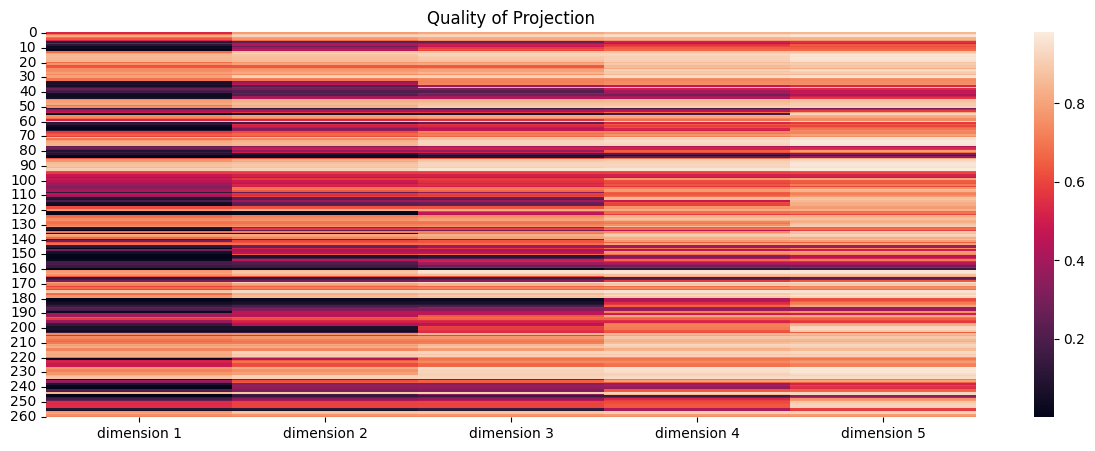

In [284]:
# X = données train standarisés
# Y = données test standarisés
# Rappel sur les fonction de la qualité de projection:
def qual_proj(X,Y,k):
    V = hyperplans(X)[1]
    X_k, X_p = np.dot(Y,V[:,:k]),np.dot(Y,V)
    quality = np.sum(X_k**2, axis=1) / np.sum(X_p**2, axis=1)
    return quality

def matrix_quality(X,Y,k):
    L = []
    for i in range(1, k+1):
        L.append(qual_proj(X,Y,i))
    return np.array(L)
T = np.transpose(matrix_quality(X,Y,5))
d = T
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.set_title("Quality of Projection")
sb.heatmap(d, ax=ax1, xticklabels=['dimension 1', 'dimension 2', 'dimension 3', 'dimension 4','dimension 5'])


plt.show()

Identification des 10 points mals projetés :

Il est totalement accepatable que la qualité de projections des individus augmente avec la dimension de l'espace choisi. Bien que la plupart des individus sont presque 80% expliqués par les 5 premières composantes, il existe d'autre qui sont mal projetés, càd qu'il sont positionnés preque ortogonalement par rapports aux cinq composantes si on les visualisent sur toutes les 19 composantes.

Trouvons quelque uns de ces individus dans nos données test.

N.B: Il faut bien noter que mal projeté ne veut pas dire anomalies, parcequ'il faut prendre de beaucoup d'autres facteurs tel que la distance..

Essayons de trouvez les 10 premiers individus mal projetés.

In [285]:
# obtenons la matrice des qualités de projection sur les 5 composantes paricipales pour chaque individu
d= T[:,4]
d

array([0.84898228, 0.93650015, 0.96878038, 0.84675484, 0.83487887,
       0.77250278, 0.5542261 , 0.51732081, 0.64295323, 0.62357029,
       0.64680882, 0.67715077, 0.67431153, 0.87860243, 0.91607484,
       0.96375217, 0.95262177, 0.96328907, 0.96085569, 0.95050813,
       0.88028421, 0.90187375, 0.87536604, 0.88084536, 0.81777596,
       0.93769345, 0.91306412, 0.89668179, 0.85398162, 0.95411204,
       0.96073078, 0.76011584, 0.73775888, 0.75122654, 0.74725885,
       0.76375085, 0.53326704, 0.86989503, 0.54036344, 0.46584306,
       0.47451925, 0.48454615, 0.42235354, 0.50821887, 0.56563231,
       0.88778091, 0.8721932 , 0.88852443, 0.89726681, 0.89348362,
       0.91618365, 0.31080154, 0.4905711 , 0.58221584, 0.81627895,
       0.92151309, 0.82825   , 0.8137778 , 0.74580989, 0.74231114,
       0.92134442, 0.57589941, 0.64168038, 0.59865147, 0.66219551,
       0.69539998, 0.75021944, 0.73149759, 0.73331881, 0.79387997,
       0.75068389, 0.94915341, 0.9488294 , 0.97580825, 0.97524

In [286]:
seuil= sorted(d)[10]
least_proj= np.where(d<seuil)
least_proj=least_proj[0]
least_proj

array([ 51,  82,  83,  84, 145, 158, 160, 166, 167, 246])

In [287]:
# les 10 moins projetés
data_test.iloc[least_proj]
pd.DataFrame(cennor(data_test.values)).iloc[least_proj]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
51,-0.207292,-0.089800,-0.083112,-0.298499,0.577975,-0.960052,-0.594781,-0.611616,0.466316,-0.308053,0.341006,0.363992,0.646659,1.026518,0.105485,-0.059194,1.181083,-0.079438,-0.315341
82,-0.650176,-0.551031,-0.623953,-0.577883,0.572681,-0.750114,-0.018807,0.343611,-0.321816,-0.300753,-1.154875,-0.488042,2.311173,-0.526802,0.101194,-0.502941,0.766889,0.972523,-0.715131
83,-0.646802,-0.334820,-0.487792,-0.098939,0.569202,-0.750114,-0.173546,0.499210,-0.516266,-0.278263,-1.044089,-0.209328,3.035136,-0.887965,0.051726,-0.498088,-0.101725,1.152969,-0.464585
84,-0.639103,-0.398041,-0.535761,0.539653,0.594963,-0.750114,-0.219395,0.300350,-0.440813,-0.278585,-1.350593,-0.130176,2.980601,-0.718082,0.241790,-0.476743,0.154506,-0.979108,-0.387684
145,-0.634062,-0.545909,-0.515320,-0.138851,0.116530,0.782432,-0.546067,-0.366006,-0.618990,-0.362157,-0.990439,0.226973,0.735778,-0.402790,0.309230,-0.863122,-0.753295,1.422358,-2.035943
158,-0.619484,-0.592724,-0.609213,-1.136651,0.220990,-0.204276,-0.313958,0.164986,-0.068496,-0.394852,-0.934797,0.340554,-1.527787,-0.276961,-0.286353,0.406794,0.864726,-0.979108,0.354812
160,-0.593726,-0.494879,-0.446462,-0.857267,0.493017,-0.204276,-0.385596,0.151031,-0.195824,-0.393414,-0.942793,0.468999,-1.430131,-0.397583,-0.354048,0.692372,1.635796,-0.979108,4.601915
166,-0.367439,0.025300,0.062020,-0.098939,0.587603,-0.918064,-0.611974,-0.421826,1.055346,-0.216910,-0.480131,0.291365,0.127819,0.769123,-0.263716,0.634584,0.726960,0.926452,0.702426
167,-0.315745,0.122680,0.137667,0.220357,0.586823,-1.211977,-0.609108,-0.475554,1.057397,-0.176174,-0.722417,0.379747,-0.123591,0.809774,-0.467892,0.801112,0.296847,0.689057,0.157600
246,-0.119072,-0.128549,-0.166756,0.140533,0.569202,-0.855083,-0.534604,-0.495091,-0.801850,-0.386610,0.348609,-0.182966,0.378395,0.464763,-0.108578,-0.606504,-0.445702,0.769042,-0.190661


In [288]:
pd.DataFrame(np.mean(cennor(data_test.values)[least_proj], axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.47929,-0.298777,-0.326868,-0.230649,0.488899,-0.582164,-0.400784,-0.09109,-0.038499,-0.309577,-0.693052,0.106112,0.713405,-0.014,-0.067116,-0.047173,0.432609,0.291564,0.170741


In [289]:
pd.DataFrame(np.std(cennor(data_test.values)[least_proj], axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.195577,0.248197,0.271921,0.481283,0.163977,0.543978,0.200715,0.397716,0.637811,0.071697,0.563795,0.311267,1.544727,0.670353,0.253118,0.592599,0.703709,0.908568,1.633666


On remarque dans ces individus beaucoup de déviations de l'intervalle de confiance $[m-σ, m+σ]$. Prennons comme exemple l'individu d'indice 158 pour Energy1, l'individu 160 pour Other3...<br>
En génarale la plupart des individus prennent des valeurs standarisés proches en valeur absolue à 1 ou même la surpasser.

essayons maintenant de visualizer ces données dans le nuage des points standarisés.

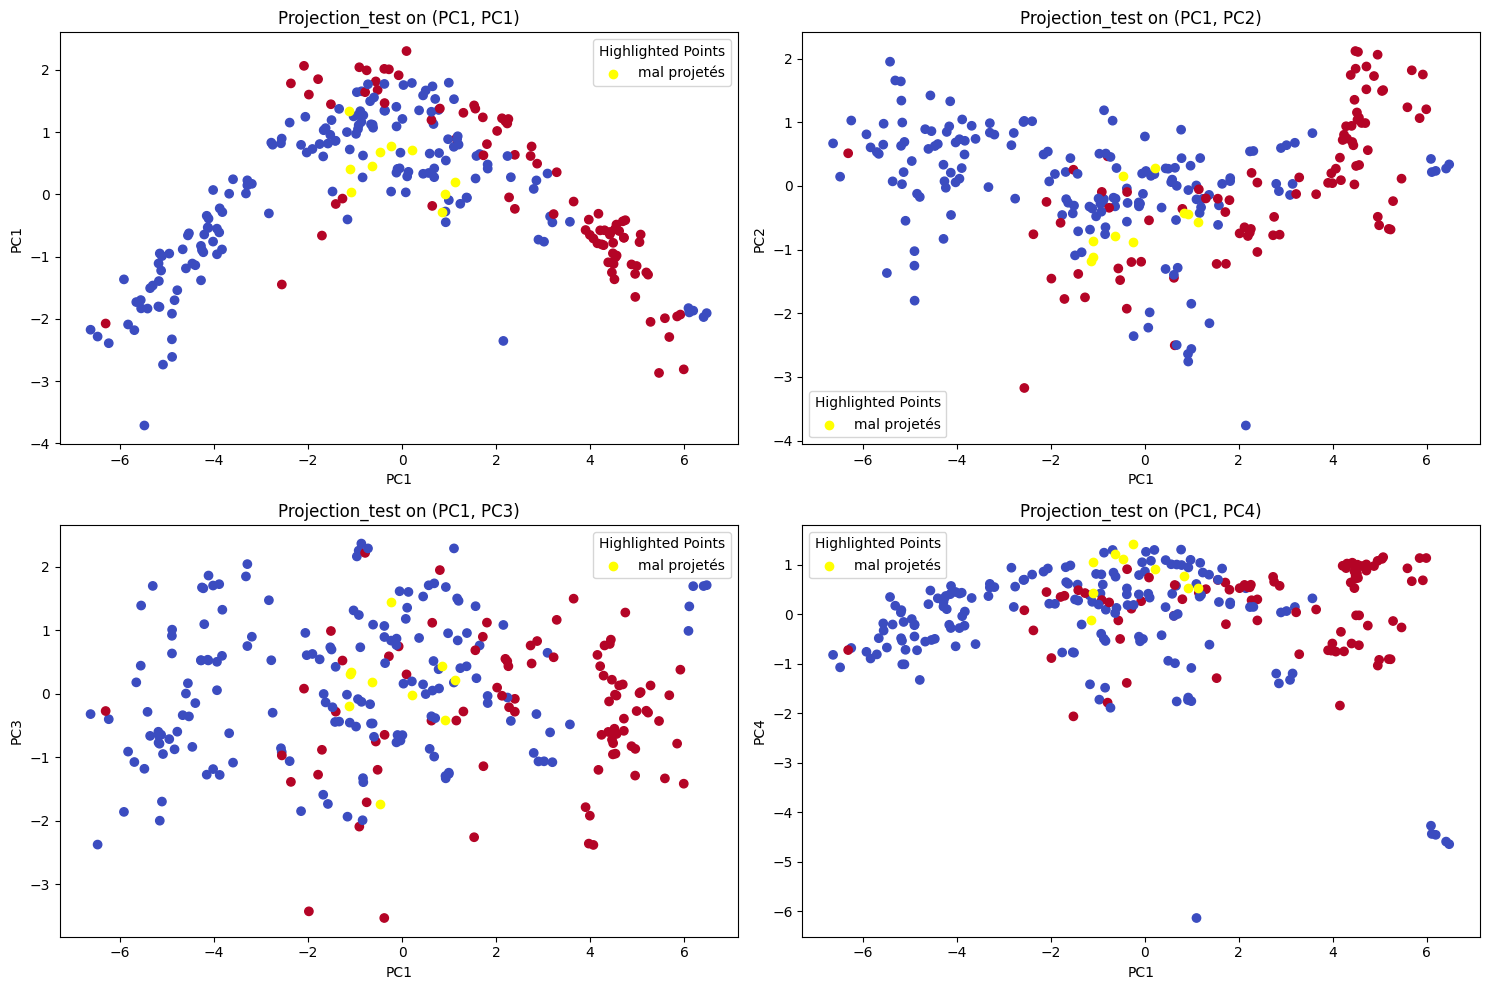

In [290]:
remaining_indices = np.setdiff1d(np.arange(len(Z2)), least_proj)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    pc_number = i + 1

    remaining_indices = np.setdiff1d(np.arange(len(Z2)), least_proj)

    scatter = ax.scatter(Z2[remaining_indices, 0], Z2[remaining_indices, pc_number], c=y_test[remaining_indices], cmap='coolwarm')
    highlighted = ax.scatter(Z2[least_proj, 0], Z2[least_proj, pc_number], c='yellow', label='mal projetés')

    ax.set_title(f'Projection_test on (PC1, PC{pc_number+1})')
    ax.set_xlabel('PC1')
    ax.set_ylabel(f'PC{pc_number+1}')
    ax.legend(handles=[highlighted], title='Highlighted Points')

plt.tight_layout()

plt.show()

Il est évident que la plupart de ces points sont encombrés avec les points originales.

Comme on vient d'évoquer la qualités de projection n'est pas le seul critère pour assurer une séparation "totale" des autres individus. Cependant il faut noter que ces individus n'ont pas pu suivre le même modèle que les autres, et une mauvaise représentation sur les 5 principales composantes induit une représentation importante de la part des autres composantes, qui expliquent moins la plupart des individus (car on a trouvé que 80% de l'inertie de la plupart des individus est expliquée par les 5 composantes principales).

## 5.4 Mise en évidence des outliers avec ACP inverse

Maintenant, prenons une autre approche pour detecter les anomalies des données test.<br>
On prendra les données test, on les centrera, on les projète sur les 5 composantes principales produits par les données train centrés, puis on les transforme dans l'hyperespace centenant tous les composantes, enfin on les décentrera pour calculer leurs distances de leurs états avant une telle transformation.<br>
Les individus les plus anormales sont ceux qui sont les plus distants du point originaire.<br>
Cette approche met en évidence les individus les plus inconvenables avec le modèle construit.

**Algorithme:**
```
X = train_data
m = mean(X)
X_c = centered(X)
Y = test_data
Y_c = centered(Y)
P5 = 5_principal_component_matrix_from_X
Y_red = Y %*% P5
Y_new = Y_red %*% transpose(P5)
Y_new = Y_new + m
distance = sum(sqrt((Y_new-Y)^2), axis=1)
```



In [291]:
X= data_train.values
m= np.mean(X, axis=0)
Y= data_test.values
Y_c= Y-m
P= hyperplans(X)[1][:,:5]
Y_red= np.dot(Y_c, P)
Y_new= np.dot(Y_red, P.T)
Y_new= Y_new+m
distance= np.sum(np.sqrt((Y_new-Y)**2), axis=1)

In [292]:
seuil= sorted(distance)[10]
anomalies= np.where(distance<seuil)[0]
anomalies

array([ 22,  23,  53,  91,  92,  93, 175, 176, 192, 227])

In [293]:
least_proj

array([ 51,  82,  83,  84, 145, 158, 160, 166, 167, 246])

Il semble que les outliers obtenus ici soint totalement différents de ceux obtenus dans la partie précedente.<br>
essayons de les visualiser dans l'espace de l'ACP centré.

In [294]:
# les 10 moins projetés
pd.DataFrame(cennor(data_test.values)).iloc[anomalies]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
22,1.265451,1.276108,1.426761,0.739213,0.594963,2.356965,-0.717999,-0.635340,1.069163,-0.188522,1.925720,0.528527,1.314835,1.613256,-1.210478,1.080670,-0.764948,0.154118,1.149668
23,1.291203,1.293143,1.407658,1.098421,0.594963,2.356965,-0.726596,-0.684182,0.974429,-0.163466,1.593569,0.554079,1.144555,1.397901,-1.242257,0.913672,-0.764579,0.176513,1.251951
53,-0.126447,0.174387,0.173820,0.020797,0.580242,-0.960052,-0.606243,-0.652086,0.460577,-0.276166,0.343868,0.438793,0.783795,1.026673,-0.118242,0.097607,0.474994,-0.160703,-0.078257
91,1.393956,1.345236,1.171650,0.260269,0.594963,0.404544,-0.695075,-0.558586,2.040207,0.562114,1.670758,1.355330,0.847764,1.502509,-1.076052,0.822278,-0.635119,-0.318113,0.656738
92,1.442295,1.398020,1.239756,0.978685,0.594963,-0.204276,-0.712268,-0.621384,1.834156,0.736895,1.676929,1.387273,0.730327,1.392052,-1.074299,0.671553,-0.658604,-0.366744,0.548658
93,1.534409,1.475107,1.383739,1.258069,0.594963,-0.204276,-0.715133,-0.642317,1.739670,0.822533,1.575996,1.408680,0.654032,1.622005,-1.092583,0.446319,-0.720573,-0.446729,0.557262
175,1.491094,1.492132,1.457514,0.579565,0.594963,0.446531,-0.723730,-0.698138,1.412624,-0.052549,1.579937,0.801567,1.505854,1.734839,-1.352103,1.242180,-0.590921,-0.460166,0.490210
176,1.481278,1.435709,1.414801,0.938773,0.594963,0.446531,-0.726596,-0.726048,1.369780,-0.023932,1.582977,0.820559,1.567393,1.703419,-1.310426,1.229780,-0.592899,-0.439050,0.565297
192,-0.217826,0.455790,0.264850,0.180445,0.594963,1.370258,-0.695075,-0.998172,0.262274,-0.205178,-0.176019,0.806909,1.106590,0.495269,-0.670349,0.859686,-0.231613,0.227704,0.206490
227,1.706960,1.356475,1.353717,0.380005,0.594963,-0.771108,-0.755251,-0.516721,1.652573,-0.249083,2.255402,0.867308,0.980518,1.864390,-1.225074,0.190151,-0.544867,-0.246447,1.208206


In [295]:
pd.DataFrame(np.mean(cennor(data_test.values)[anomalies],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.126237,1.170211,1.129427,0.643424,0.593491,0.524208,-0.707397,-0.673297,1.281545,0.096264,1.402914,0.896903,1.063566,1.435231,-1.037186,0.75539,-0.502913,-0.187962,0.655622


In [296]:
pd.DataFrame(np.std(cennor(data_test.values)[anomalies],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.660068,0.437344,0.463089,0.401983,0.004416,1.113662,0.037451,0.123403,0.557296,0.41096,0.699397,0.346341,0.305207,0.383494,0.355838,0.382485,0.356894,0.260731,0.41255


On remarque que dans ces anomalies les valeurs de variables prédictives est encore plus grand et dépasse 1 en valeur absolue (et donc hors de l'interval de confiance standardisé $[-1,1]$).

On remarque que ce modèle, sachant que la première composante explique plus de 95% de l'inertie (cas ACP centré), a bien réussi à séparer les points anormales que le modèle précedent, ceci peut être bien distingué des valeurs standardisés obtenus.<br>
Essayons maintenant de les comparer avec les outliers obtenus de la forêt d'isolement.

In [328]:
outliers= pd.read_csv("ind_points_anormales.csv")
outliers= np.array(outliers["x"])
outliers

array([177, 172, 115,  25,  38,  26,  72,  49,  50, 227])

In [329]:
#anomalies des forets d'isolement
pd.DataFrame(cennor(data_test.values)).iloc[outliers]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
177,3.004622,1.852703,2.252278,0.779125,0.594963,-0.477195,-0.758117,-0.607429,1.118340,-0.280698,3.309822,1.206423,3.160131,1.798436,-1.407940,0.831063,0.749113,-0.126789,1.758099
172,-0.682937,-0.864722,-0.889226,-1.695419,-1.153159,1.274526,2.777960,2.020317,-0.720715,-0.139294,-0.371682,-1.145950,-0.255773,-1.216781,1.178307,-0.923127,-0.032348,2.379617,-2.662346
115,-0.729157,-0.914967,-0.850814,1.018597,0.305141,-0.619743,0.264881,-0.363215,0.255140,2.266299,-1.006083,-0.806069,-0.874159,-0.123892,0.893298,-0.648113,-0.451866,-0.979108,-0.222815
25,-0.772737,-1.118369,-1.081572,-1.735331,-1.727279,1.454233,2.219180,1.845878,-1.152647,-0.402952,-0.490101,-1.523492,-1.194403,-0.775020,1.645518,-0.949476,-0.207844,2.547905,-0.163160
38,-0.693821,-0.921724,-0.918128,-0.258587,0.149148,-0.981046,0.356579,0.343611,-0.772758,-0.398256,-0.802872,0.008095,-0.810651,-0.723796,0.410289,-0.713668,0.719716,2.544066,2.039044
26,-0.771831,-1.103923,-1.072086,-1.695419,-1.672076,1.454233,2.153272,1.832621,-1.216242,-0.403014,-0.523118,-1.462563,-1.025167,-0.753732,1.611513,-0.957953,-0.135584,2.453203,-0.702630
72,1.878240,1.382788,1.359113,0.579565,0.594963,-1.065021,-0.726596,-0.677205,1.154991,-0.295982,2.740397,1.017872,1.404020,2.009760,-1.380083,0.833865,-0.508759,-0.002653,2.474603
49,3.491130,1.813717,2.144732,-0.218675,0.594963,-1.044027,-0.717999,-0.837689,2.209258,-0.211635,2.828733,1.292654,1.737221,1.711514,-1.369622,0.255151,-0.773689,-0.559347,0.140923
50,3.621251,1.928830,2.408716,0.659389,0.594963,-1.044027,-0.726596,-0.837689,2.243887,-0.168785,2.094452,1.333940,1.489992,1.956598,-1.297945,0.057973,-0.774097,-0.979108,0.194195
227,1.706960,1.356475,1.353717,0.380005,0.594963,-0.771108,-0.755251,-0.516721,1.652573,-0.249083,2.255402,0.867308,0.980518,1.864390,-1.225074,0.190151,-0.544867,-0.246447,1.208206


In [330]:
pd.DataFrame(np.mean(cennor(data_test.values)[outliers],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.005172,0.341081,0.470673,-0.218675,-0.112341,-0.181918,0.408731,0.220248,0.477183,-0.02834,1.003495,0.078822,0.461173,0.574748,-0.094174,-0.202413,-0.196022,0.703134,0.406412


In [331]:
pd.DataFrame(np.std(cennor(data_test.values)[least_proj],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.195577,0.248197,0.271921,0.481283,0.163977,0.543978,0.200715,0.397716,0.637811,0.071697,0.563795,0.311267,1.544727,0.670353,0.253118,0.592599,0.703709,0.908568,1.633666


In [332]:
#anomalies de l'ACP
pd.DataFrame(cennor(data_test.values)).iloc[least_proj]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
51,-0.207292,-0.089800,-0.083112,-0.298499,0.577975,-0.960052,-0.594781,-0.611616,0.466316,-0.308053,0.341006,0.363992,0.646659,1.026518,0.105485,-0.059194,1.181083,-0.079438,-0.315341
82,-0.650176,-0.551031,-0.623953,-0.577883,0.572681,-0.750114,-0.018807,0.343611,-0.321816,-0.300753,-1.154875,-0.488042,2.311173,-0.526802,0.101194,-0.502941,0.766889,0.972523,-0.715131
83,-0.646802,-0.334820,-0.487792,-0.098939,0.569202,-0.750114,-0.173546,0.499210,-0.516266,-0.278263,-1.044089,-0.209328,3.035136,-0.887965,0.051726,-0.498088,-0.101725,1.152969,-0.464585
84,-0.639103,-0.398041,-0.535761,0.539653,0.594963,-0.750114,-0.219395,0.300350,-0.440813,-0.278585,-1.350593,-0.130176,2.980601,-0.718082,0.241790,-0.476743,0.154506,-0.979108,-0.387684
145,-0.634062,-0.545909,-0.515320,-0.138851,0.116530,0.782432,-0.546067,-0.366006,-0.618990,-0.362157,-0.990439,0.226973,0.735778,-0.402790,0.309230,-0.863122,-0.753295,1.422358,-2.035943
158,-0.619484,-0.592724,-0.609213,-1.136651,0.220990,-0.204276,-0.313958,0.164986,-0.068496,-0.394852,-0.934797,0.340554,-1.527787,-0.276961,-0.286353,0.406794,0.864726,-0.979108,0.354812
160,-0.593726,-0.494879,-0.446462,-0.857267,0.493017,-0.204276,-0.385596,0.151031,-0.195824,-0.393414,-0.942793,0.468999,-1.430131,-0.397583,-0.354048,0.692372,1.635796,-0.979108,4.601915
166,-0.367439,0.025300,0.062020,-0.098939,0.587603,-0.918064,-0.611974,-0.421826,1.055346,-0.216910,-0.480131,0.291365,0.127819,0.769123,-0.263716,0.634584,0.726960,0.926452,0.702426
167,-0.315745,0.122680,0.137667,0.220357,0.586823,-1.211977,-0.609108,-0.475554,1.057397,-0.176174,-0.722417,0.379747,-0.123591,0.809774,-0.467892,0.801112,0.296847,0.689057,0.157600
246,-0.119072,-0.128549,-0.166756,0.140533,0.569202,-0.855083,-0.534604,-0.495091,-0.801850,-0.386610,0.348609,-0.182966,0.378395,0.464763,-0.108578,-0.606504,-0.445702,0.769042,-0.190661


In [333]:
pd.DataFrame(np.mean(cennor(data_test.values)[least_proj],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.47929,-0.298777,-0.326868,-0.230649,0.488899,-0.582164,-0.400784,-0.09109,-0.038499,-0.309577,-0.693052,0.106112,0.713405,-0.014,-0.067116,-0.047173,0.432609,0.291564,0.170741


In [334]:
pd.DataFrame(np.std(cennor(data_test.values)[least_proj],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.195577,0.248197,0.271921,0.481283,0.163977,0.543978,0.200715,0.397716,0.637811,0.071697,0.563795,0.311267,1.544727,0.670353,0.253118,0.592599,0.703709,0.908568,1.633666


In [335]:
#anomalies de l'ACP inverse
pd.DataFrame(cennor(data_test.values)).iloc[anomalies]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
22,1.265451,1.276108,1.426761,0.739213,0.594963,2.356965,-0.717999,-0.635340,1.069163,-0.188522,1.925720,0.528527,1.314835,1.613256,-1.210478,1.080670,-0.764948,0.154118,1.149668
23,1.291203,1.293143,1.407658,1.098421,0.594963,2.356965,-0.726596,-0.684182,0.974429,-0.163466,1.593569,0.554079,1.144555,1.397901,-1.242257,0.913672,-0.764579,0.176513,1.251951
53,-0.126447,0.174387,0.173820,0.020797,0.580242,-0.960052,-0.606243,-0.652086,0.460577,-0.276166,0.343868,0.438793,0.783795,1.026673,-0.118242,0.097607,0.474994,-0.160703,-0.078257
91,1.393956,1.345236,1.171650,0.260269,0.594963,0.404544,-0.695075,-0.558586,2.040207,0.562114,1.670758,1.355330,0.847764,1.502509,-1.076052,0.822278,-0.635119,-0.318113,0.656738
92,1.442295,1.398020,1.239756,0.978685,0.594963,-0.204276,-0.712268,-0.621384,1.834156,0.736895,1.676929,1.387273,0.730327,1.392052,-1.074299,0.671553,-0.658604,-0.366744,0.548658
93,1.534409,1.475107,1.383739,1.258069,0.594963,-0.204276,-0.715133,-0.642317,1.739670,0.822533,1.575996,1.408680,0.654032,1.622005,-1.092583,0.446319,-0.720573,-0.446729,0.557262
175,1.491094,1.492132,1.457514,0.579565,0.594963,0.446531,-0.723730,-0.698138,1.412624,-0.052549,1.579937,0.801567,1.505854,1.734839,-1.352103,1.242180,-0.590921,-0.460166,0.490210
176,1.481278,1.435709,1.414801,0.938773,0.594963,0.446531,-0.726596,-0.726048,1.369780,-0.023932,1.582977,0.820559,1.567393,1.703419,-1.310426,1.229780,-0.592899,-0.439050,0.565297
192,-0.217826,0.455790,0.264850,0.180445,0.594963,1.370258,-0.695075,-0.998172,0.262274,-0.205178,-0.176019,0.806909,1.106590,0.495269,-0.670349,0.859686,-0.231613,0.227704,0.206490
227,1.706960,1.356475,1.353717,0.380005,0.594963,-0.771108,-0.755251,-0.516721,1.652573,-0.249083,2.255402,0.867308,0.980518,1.864390,-1.225074,0.190151,-0.544867,-0.246447,1.208206


In [336]:
pd.DataFrame(np.mean(cennor(data_test.values)[anomalies],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.126237,1.170211,1.129427,0.643424,0.593491,0.524208,-0.707397,-0.673297,1.281545,0.096264,1.402914,0.896903,1.063566,1.435231,-1.037186,0.75539,-0.502913,-0.187962,0.655622


In [337]:
pd.DataFrame(np.std(cennor(data_test.values)[anomalies],axis=0)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.660068,0.437344,0.463089,0.401983,0.004416,1.113662,0.037451,0.123403,0.557296,0.41096,0.699397,0.346341,0.305207,0.383494,0.355838,0.382485,0.356894,0.260731,0.41255


Bien que les anomalies de l'ACP inverse (ceux les plus incompatibles au modèle de l'ACP) sont de valeurs significatives que les anomalies détéctés par qualité de projection (la plupart des valeurs dépassent 1 en valeur absolue). Les anomalies détectés par la forêt d'isolement sont plus importantes puisque des valeurs dépassent même 3 en valeur absolue.

Notons qu'en ACP inverse, on a utilisé la distance comme métrique pour faire réveler les anomalies. Il en existe d'autres métriques tels que:<br>
- $R_i^2 = 1 - \frac{Σ(X_ij-fij)^2}{X_ij^2}$ : plus R_i^2 proche de 1 le point est normale.<br>
- $RMSE_i = \sqrt{\overline{(X_i-f_i)^2}}$ : plus il est elevé le point est anormale
- $NRMSE_i = \sqrt{\frac{\overline{(X_i-f_i)^2}}{\overline{(X_i)^2}}}$

# Partie 6: AFD sur $\mathbb{R}^p$

commençons par importer les packages nécessaires.

In [338]:
import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

on essaie de lire les données train de 2.(a) à partie du ficher importé $'train\_data.csv'$.

In [339]:
data=pd.read_csv("train_data.csv",delimiter=',')

In [340]:
data.shape

(609, 20)

In [341]:
data.head()

,Income_Inequality,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
0,L,43044.997120,32416.819912,43757.013606,64,100.00000,42.0,2.7,1.7500,0.665518,1.258443e+06,1.202421,3.391014,0.794753,2.181061,0.151155,9.228086,0.498563,13.08,7.12404
1,H,58207.578310,49278.816384,62495.418887,76,100.00000,89.6,6.6,1.7655,0.915723,6.694028e+07,1.000000,3.738714,1.000000,1.549218,11.175388,14.823245,0.427546,0.00,5.10922
2,H,21452.921520,25778.473448,40041.105564,34,100.00000,85.0,8.5,2.0530,0.452552,2.227306e+05,0.442042,2.264699,1.038013,0.451604,0.000000,21.394807,20.462117,20.30,3.19000
3,H,5701.674149,8746.013481,11436.344113,43,91.09951,67.0,18.3,2.4870,0.300588,9.182161e+05,0.606352,2.715935,0.547731,-0.187987,32.137705,1.617522,9.999279,39.73,2.92276
4,L,12024.609507,21280.180517,25957.547446,57,100.00000,154.0,5.0,1.3200,0.451241,2.394525e+06,0.560190,3.327214,0.865860,0.768318,14.084801,7.516889,3.157677,18.09,4.93554


In [342]:
#visualisons les differentes classes
set(data["Income_Inequality"])

{'H', 'L'}

Maintenant on essaie de créer un encoder y qui regroupe les classes des différents entité ordonnés selon les identifiants des lignes.<br>
Cet encoder assigne des chiffres à partir de 0 selon l'ordre alphabétique de la classe. Dans notre cas: "H"->0(négatifs) et "L"->1(positifs)

In [343]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(data["Income_Inequality"])
np.unique(y)

array([0, 1])

Maintenant qu'on a créée un encoder, essayer de prélever la variable à classifier de notre base de données.

In [344]:
#data sans les classifications
X = data.drop(["Income_Inequality"], axis=1)
n,p= X.shape[0], X.shape[1]
K= len(set(data["Income_Inequality"]));K

2

On crée une fonction pour centrer nos données

In [345]:
def center(X):
    m=np.mean(X, axis=0)
    return X-m

## 6.1 Calcul des variances

On crée une fonction pour le calcul respective de la variance totale, la variance inter-classes, puis la variance intra-classes.

In [346]:
#fonction qui retourne V,B,W,groupes
def var(X,y):
    n,p= X.shape[0], X.shape[1]
    grp=np.unique(y)
    m=np.mean(X,axis=0)
    W=np.zeros((p,p))
    B=np.zeros((p,p))
    V=np.zeros((p,p))
    for classe in grp:
        X_c=X[y==classe]
        n_c=X_c.shape[0]
        m_c=np.mean(X_c,axis=0)
        W=W+(1/n)*((X_c-m_c).T.dot((X_c-m_c)))
        inter_diff= (m_c-m).values.reshape(p,1)
        B+=n_c*((inter_diff).dot((inter_diff).T))
    V= (1/n)*((X-m)).T.dot((X-m))
    B=(1/n)*B
    return V,B,W,grp

On éssaie aussi de créer une fonction pour faire retourner les variances intra-classes ordonnées selon les groupes assignés par le encoder y.

In [347]:
#calcul des Wk: dispersion de chaque cluster
def intra_var(X,y):
    n,p= X.shape[0], X.shape[1]
    grp=np.unique(y)
    L=[]
    for classe in grp:
        W=np.zeros((p,p))
        X_c=X[y==classe]
        n_c=X_c.shape[0]
        m_c=np.mean(X_c,axis=0)
        W=W+(1/n)*((X_c-m_c).T.dot((X_c-m_c)))
        L.append(W)
    return L

On fera la même chose pour les variables inter-classes.

In [348]:
#calcul des Bk: dispersions des centroides des clusters
def inter_var(X,y):
    n,p= X.shape[0], X.shape[1]
    grp=np.unique(y)
    m=np.mean(X,axis=0)
    L=[]
    for classe in grp:
        B=np.zeros((p,p))
        X_c=X[y==classe]
        n_c=X_c.shape[0]
        m_c=np.mean(X_c,axis=0)
        inter_diff= (m_c-m).values.reshape(p,1)
        B+=n_c*((inter_diff).dot((inter_diff).T))
        B=(1/n)*B
        L.append(B)
    return L

In [349]:
V=var(X,y)[0]

essayons de visualiser les variances.

In [350]:
#W0 et W1
W0,W1= intra_var(X,y)[0],intra_var(X,y)[1]

In [351]:
W0

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,5.263097e+07,4.600477e+07,6.121001e+07,7.027764e+04,8.101614e+04,-4.660518e+03,-9.770219e+04,-3.897434e+03,823.273784,2.980376e+10,707.048774,2.142946e+03,730.314740,2.772991e+03,-6.246300e+04,1.605334e+04,-8.409584e+03,-1.574865e+04,1588.203648
Eco2,4.600477e+07,4.565289e+07,6.048476e+07,7.863079e+04,1.016017e+05,-8.335034e+03,-1.174045e+05,-4.970101e+03,819.082426,2.057457e+10,563.325877,2.324091e+03,822.695453,2.740023e+03,-7.227657e+04,1.706927e+04,-8.277839e+03,-1.638693e+04,1224.883214
Eco3,6.121001e+07,6.048476e+07,8.147415e+07,1.027032e+05,1.346632e+05,-1.369024e+04,-1.561873e+05,-6.560618e+03,1104.355515,3.005203e+10,733.363415,2.966739e+03,1109.199196,3.654801e+03,-9.718233e+04,2.389535e+04,-9.163033e+03,-2.142625e+04,1287.083858
Energy1,7.027764e+04,7.863079e+04,1.027032e+05,3.205067e+02,3.262816e+02,-8.171190e+01,-3.771280e+02,-1.657104e+01,2.025973,5.466055e+07,0.825518,6.317581e+00,1.607850,6.698193e+00,-1.762299e+02,2.382607e+01,-4.109165e+01,-9.508945e+01,5.429550
Energy2,8.101614e+04,1.016017e+05,1.346632e+05,3.262816e+02,5.561371e+02,-1.775175e+02,-5.456749e+02,-2.489019e+01,2.421499,5.850019e+07,1.031327,8.925587e+00,2.485750,7.821018e+00,-2.674212e+02,3.749024e+01,-5.181418e+01,-5.255733e+01,4.232253
Energy3,-4.660518e+03,-8.335034e+03,-1.369024e+04,-8.171190e+01,-1.775175e+02,1.082574e+03,2.115924e+02,6.912061e+00,-0.094913,3.765113e+07,0.326213,-1.167078e+00,-0.559030,-2.725119e+00,1.034538e+02,8.404881e+00,3.776495e+01,5.690416e+01,-2.432078
Health1,-9.770219e+04,-1.174045e+05,-1.561873e+05,-3.771280e+02,-5.456749e+02,2.115924e+02,7.516630e+02,2.902923e+01,-2.706795,-6.184714e+07,-1.106163,-1.008572e+01,-2.345521,-9.881651e+00,2.808639e+02,-4.340785e+01,5.799704e+01,8.175437e+01,-8.875654
Health2,-3.897434e+03,-4.970101e+03,-6.560618e+03,-1.657104e+01,-2.489019e+01,6.912061e+00,2.902923e+01,1.352912e+00,-0.127393,-3.387609e+06,-0.046298,-4.334659e-01,-0.102598,-4.132460e-01,1.223912e+01,-1.885050e+00,2.574304e+00,2.921164e+00,-0.336025
Finan1,8.232738e+02,8.190824e+02,1.104356e+03,2.025973e+00,2.421499e+00,-9.491322e-02,-2.706795e+00,-1.273930e-01,0.026349,8.604241e+05,0.011040,5.102524e-02,0.013148,6.669874e-02,-1.381213e+00,3.137320e-01,-2.479232e-01,-2.548736e-01,0.035745
Finan2,2.980376e+10,2.057457e+10,3.005203e+10,5.466055e+07,5.850019e+07,3.765113e+07,-6.184714e+07,-3.387609e+06,860424.131484,1.140540e+14,413527.589577,1.307781e+06,152249.177924,1.745526e+06,-2.949124e+07,1.244227e+07,-7.439954e+06,-1.629440e+07,297001.952776


In [352]:
W1

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,2.195040e+08,8.996067e+07,1.726311e+08,6.371270e+04,1.628519e+04,-2.467966e+05,-6.018371e+04,-2559.595406,1850.711025,9.229131e+09,2697.329452,1219.007365,1324.883294,7147.974715,-6.502546e+04,31257.939442,1.389989e+03,-4.834328e+04,2733.646686
Eco2,8.996067e+07,4.651992e+07,7.516026e+07,4.493658e+04,1.186258e+04,-1.068736e+05,-3.936701e+04,-1851.391284,968.679618,8.707170e+09,1292.735480,777.086757,664.385986,3754.631092,-3.464265e+04,12777.151652,-4.906876e+03,-2.709863e+04,1142.480804
Eco3,1.726311e+08,7.516026e+07,1.587241e+08,6.055505e+04,1.732803e+04,-1.847324e+05,-5.862401e+04,-2646.652224,1426.402808,7.868628e+09,1896.729909,865.620950,1045.894713,5681.736414,-5.933720e+04,37625.155919,8.495667e+03,-4.466969e+04,557.923546
Energy1,6.371270e+04,4.493658e+04,6.055505e+04,1.100944e+02,2.809977e+01,-6.086828e+01,-5.928969e+01,-3.289647,0.896795,1.330618e+07,0.904530,1.239036,0.574271,3.773107,-3.833791e+01,3.454450,-2.215324e+01,-4.921977e+01,0.662021
Energy2,1.628519e+04,1.186258e+04,1.732803e+04,2.809977e+01,3.227589e+01,-3.295982e+00,-4.052897e+01,-1.973885,0.214431,1.406620e+06,0.185380,0.859072,0.249776,0.819073,-1.906849e+01,3.728724,-4.791247e+00,-8.953912e+00,0.553260
Energy3,-2.467966e+05,-1.068736e+05,-1.847324e+05,-6.086828e+01,-3.295982e+00,1.690769e+03,4.252208e+01,-0.222113,-2.714028,-3.478782e+07,-3.405131,-1.219906,-1.970279,-9.235506,4.746092e+01,-29.094034,-4.117916e+00,1.076354e+02,1.192241
Health1,-6.018371e+04,-3.936701e+04,-5.862401e+04,-5.928969e+01,-4.052897e+01,4.252208e+01,7.848840e+01,3.934807,-0.814777,-6.753537e+06,-0.892774,-1.499960,-0.565398,-3.139208,4.581300e+01,-10.598623,9.153334e+00,2.898182e+01,-1.008801
Health2,-2.559595e+03,-1.851391e+03,-2.646652e+03,-3.289647e+00,-1.973885e+00,-2.221131e-01,3.934807e+00,0.252733,-0.041396,-5.309470e+05,-0.040216,-0.080297,-0.018073,-0.158930,2.196806e+00,-0.440663,7.969395e-01,1.261302e+00,-0.026698
Finan1,1.850711e+03,9.686796e+02,1.426403e+03,8.967954e-01,2.144308e-01,-2.714028e+00,-8.147766e-01,-0.041396,0.026258,3.407525e+05,0.030450,0.016193,0.012983,0.085626,-6.559310e-01,0.193042,-2.184196e-01,-5.569713e-01,0.019096
Finan2,9.229131e+09,8.707170e+09,7.868628e+09,1.330618e+07,1.406620e+06,-3.478782e+07,-6.753537e+06,-530946.993451,340752.485943,1.646788e+13,270792.971197,172407.197916,59813.788922,867810.281181,-4.451896e+06,260870.719622,-5.107444e+06,-7.308856e+06,-497580.640186


In [353]:
#B
B= pd.DataFrame(var(X,y)[1], index= V.index.tolist(), columns= V.index.tolist())
B

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,1.271816e+08,7.795462e+07,1.216771e+08,117945.356069,114374.143989,68970.330195,-146654.039301,-6271.554986,1329.311630,-1.285701e+08,1435.005863,4994.632727,1064.561195,5510.311617,-146170.634900,26605.757587,-12005.249458,-30263.077841,3437.113421
Eco2,7.795462e+07,4.778148e+07,7.458073e+07,72293.387741,70104.450183,42274.651496,-89890.078595,-3844.084849,814.787833,-7.880573e+07,879.572021,3061.408541,652.511788,3377.488589,-89593.780860,16307.724301,-7358.493653,-18549.440974,2106.743169
Eco3,1.216771e+08,7.458073e+07,1.164109e+08,112840.658518,109424.009179,65985.281123,-140306.824453,-6000.120887,1271.778769,-1.230056e+08,1372.898535,4778.464068,1018.486783,5271.824277,-139844.341887,25454.255314,-11485.659967,-28953.286048,3288.354495
Energy1,1.179454e+05,7.229339e+04,1.128407e+05,109.379914,106.068051,63.961558,-136.003712,-5.816101,1.232774,-1.192331e+05,1.330793,4.631912,0.987251,5.110141,-135.555413,24.673591,-11.133403,-28.065309,3.187503
Energy2,1.143741e+05,7.010445e+04,1.094240e+05,106.068051,102.856466,62.024896,-131.885719,-5.639998,1.195448,-1.156229e+05,1.290498,4.491664,0.957358,4.955414,-131.450994,23.926511,-10.796300,-27.215533,3.090990
Energy3,6.897033e+04,4.227465e+04,6.598528e+04,63.961558,62.024896,37.402488,-79.530227,-3.401053,0.720883,-6.972335e+04,0.778201,2.708581,0.577310,2.988232,-79.268077,14.428255,-6.510426,-16.411614,1.863941
Health1,-1.466540e+05,-8.989008e+04,-1.403068e+05,-136.003712,-131.885719,-79.530227,169.107918,7.231779,-1.532840,1.482552e+05,-1.654716,-5.759350,-1.227554,-6.353983,168.550501,-30.679307,13.843347,34.896591,-3.963362
Health2,-6.271555e+03,-3.844085e+03,-6.000121e+03,-5.816101,-5.639998,-3.401053,7.231779,0.309262,-0.065551,6.340028e+03,-0.070763,-0.246294,-0.052495,-0.271724,7.207941,-1.311979,0.592001,1.492328,-0.169490
Finan1,1.329312e+03,8.147878e+02,1.271779e+03,1.232774,1.195448,0.720883,-1.532840,-0.065551,0.013894,-1.343825e+03,0.014999,0.052204,0.011127,0.057594,-1.527787,0.278085,-0.125480,-0.316312,0.035925
Finan2,-1.285701e+08,-7.880573e+07,-1.230056e+08,-119233.094085,-115622.891190,-69723.354470,148255.221305,6340.028388,-1343.825174,1.299739e+08,-1450.673386,-5049.164577,-1076.184170,-5570.473695,147766.539052,-26896.241643,12136.323852,30593.492849,-3474.640135


In [354]:
#W
W= pd.DataFrame(var(X,y)[2], index= V.index.tolist(), columns= V.index.tolist())
W

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,2.721350e+08,1.359654e+08,2.338411e+08,1.339903e+05,9.730133e+04,-2.514572e+05,-1.578859e+05,-6.457030e+03,2.673985e+03,3.903289e+10,3404.378226,3.361953e+03,2055.198034,9.920966e+03,-1.274885e+05,4.731128e+04,-7.019594e+03,-6.409192e+04,4321.850335
Eco2,1.359654e+08,9.217282e+07,1.356450e+08,1.235674e+05,1.134643e+05,-1.152086e+05,-1.567715e+05,-6.821493e+03,1.787762e+03,2.928174e+10,1856.061357,3.101178e+03,1487.081439,6.494654e+03,-1.069192e+05,2.984642e+04,-1.318472e+04,-4.348555e+04,2367.364019
Eco3,2.338411e+08,1.356450e+08,2.401982e+08,1.632582e+05,1.519913e+05,-1.984226e+05,-2.148113e+05,-9.207270e+03,2.530758e+03,3.792066e+10,2630.093324,3.832360e+03,2155.093909,9.336537e+03,-1.565195e+05,6.152050e+04,-6.673668e+02,-6.609593e+04,1845.007404
Energy1,1.339903e+05,1.235674e+05,1.632582e+05,4.306010e+02,3.543814e+02,-1.425802e+02,-4.364177e+02,-1.986069e+01,2.922768e+00,6.796672e+07,1.730047,7.556616e+00,2.182120,1.047130e+01,-2.145678e+02,2.728052e+01,-6.324490e+01,-1.443092e+02,6.091571
Energy2,9.730133e+04,1.134643e+05,1.519913e+05,3.543814e+02,5.884130e+02,-1.808135e+02,-5.862039e+02,-2.686408e+01,2.635930e+00,5.990681e+07,1.216707,9.784660e+00,2.735526,8.640091e+00,-2.864897e+02,4.121896e+01,-5.660542e+01,-6.151124e+01,4.785512
Energy3,-2.514572e+05,-1.152086e+05,-1.984226e+05,-1.425802e+02,-1.808135e+02,2.773343e+03,2.541144e+02,6.689948e+00,-2.808941e+00,2.863311e+06,-3.078918,-2.386984e+00,-2.529310,-1.196063e+01,1.509148e+02,-2.068915e+01,3.364704e+01,1.645395e+02,-1.239838
Health1,-1.578859e+05,-1.567715e+05,-2.148113e+05,-4.364177e+02,-5.862039e+02,2.541144e+02,8.301514e+02,3.296403e+01,-3.521572e+00,-6.860068e+07,-1.998937,-1.158568e+01,-2.910918,-1.302086e+01,3.266769e+02,-5.400647e+01,6.715037e+01,1.107362e+02,-9.884455
Health2,-6.457030e+03,-6.821493e+03,-9.207270e+03,-1.986069e+01,-2.686408e+01,6.689948e+00,3.296403e+01,1.605645e+00,-1.687889e-01,-3.918556e+06,-0.086514,-5.137624e-01,-0.120671,-5.721761e-01,1.443593e+01,-2.325713e+00,3.371243e+00,4.182466e+00,-0.362723
Finan1,2.673985e+03,1.787762e+03,2.530758e+03,2.922768e+00,2.635930e+00,-2.808941e+00,-3.521572e+00,-1.687889e-01,5.260715e-02,1.201177e+06,0.041490,6.721808e-02,0.026131,1.523251e-01,-2.037144e+00,5.067737e-01,-4.663429e-01,-8.118448e-01,0.054841
Finan2,3.903289e+10,2.928174e+10,3.792066e+10,6.796672e+07,5.990681e+07,2.863311e+06,-6.860068e+07,-3.918556e+06,1.201177e+06,1.305218e+14,684320.560774,1.480188e+06,212062.966846,2.613336e+06,-3.394314e+07,1.270314e+07,-1.254740e+07,-2.360326e+07,-200578.687410


In [355]:
#V
V=var(X,y)[0]
V

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,3.993165e+08,2.139201e+08,3.555182e+08,2.519357e+05,2.116755e+05,-1.824868e+05,-3.045399e+05,-1.272858e+04,4.003296e+03,3.890432e+10,4839.384088,8.356586e+03,3119.759229,1.543128e+04,-2.736591e+05,7.391704e+04,-1.902484e+04,-9.435500e+04,7758.963755
Eco2,2.139201e+08,1.399543e+08,2.102257e+08,1.958608e+05,1.835688e+05,-7.293399e+04,-2.466616e+05,-1.066558e+04,2.602550e+03,2.920294e+10,2735.633379,6.162587e+03,2139.593227,9.872143e+03,-1.965130e+05,4.615415e+04,-2.054321e+04,-6.203500e+04,4474.107188
Eco3,3.555182e+08,2.102257e+08,3.566091e+08,2.760989e+05,2.614153e+05,-1.324374e+05,-3.551181e+05,-1.520739e+04,3.802537e+03,3.779765e+10,4002.991859,8.610824e+03,3173.580692,1.460836e+04,-2.963639e+05,8.697476e+04,-1.215303e+04,-9.504922e+04,5133.361899
Energy1,2.519357e+05,1.958608e+05,2.760989e+05,5.399809e+02,4.604495e+02,-7.861862e+01,-5.724214e+02,-2.567679e+01,4.155543e+00,6.784749e+07,3.060840,1.218853e+01,3.169371,1.558144e+01,-3.501232e+02,5.195411e+01,-7.437830e+01,-1.723745e+02,9.279074
Energy2,2.116755e+05,1.835688e+05,2.614153e+05,4.604495e+02,6.912695e+02,-1.187886e+02,-7.180896e+02,-3.250408e+01,3.831377e+00,5.979119e+07,2.507205,1.427632e+01,3.692884,1.359550e+01,-4.179407e+02,6.514548e+01,-6.740172e+01,-8.872677e+01,7.876502
Energy3,-1.824868e+05,-7.293399e+04,-1.324374e+05,-7.861862e+01,-1.187886e+02,2.810746e+03,1.745842e+02,3.288894e+00,-2.088058e+00,2.793587e+06,-2.300717,3.215962e-01,-1.952000,-8.972393e+00,7.164668e+01,-6.260898e+00,2.713661e+01,1.481279e+02,0.624103
Health1,-3.045399e+05,-2.466616e+05,-3.551181e+05,-5.724214e+02,-7.180896e+02,1.745842e+02,9.992593e+02,4.019581e+01,-5.054411e+00,-6.845242e+07,-3.653653,-1.734503e+01,-4.138472,-1.937484e+01,4.952274e+02,-8.468578e+01,8.099372e+01,1.456328e+02,-13.847817
Health2,-1.272858e+04,-1.066558e+04,-1.520739e+04,-2.567679e+01,-3.250408e+01,3.288894e+00,4.019581e+01,1.914906e+00,-2.343397e-01,-3.912216e+06,-0.157277,-7.600569e-01,-0.173166,-8.438996e-01,2.164387e+01,-3.637691e+00,3.963244e+00,5.674794e+00,-0.532213
Finan1,4.003296e+03,2.602550e+03,3.802537e+03,4.155543e+00,3.831377e+00,-2.088058e+00,-5.054411e+00,-2.343397e-01,6.650122e-02,1.199833e+06,0.056489,1.194224e-01,0.037258,2.099193e-01,-3.564931e+00,7.848592e-01,-5.918227e-01,-1.128157e+00,0.090766
Finan2,3.890432e+10,2.920294e+10,3.779765e+10,6.784749e+07,5.979119e+07,2.793587e+06,-6.845242e+07,-3.912216e+06,1.199833e+06,1.305220e+14,682869.887388,1.475139e+06,210986.782676,2.607766e+06,-3.379537e+07,1.267624e+07,-1.253526e+07,-2.357266e+07,-204053.327544


In [356]:
B+W

,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
Eco1,3.993165e+08,2.139201e+08,3.555182e+08,2.519357e+05,2.116755e+05,-1.824868e+05,-3.045399e+05,-1.272858e+04,4.003296e+03,3.890432e+10,4839.384088,8.356586e+03,3119.759229,1.543128e+04,-2.736591e+05,7.391704e+04,-1.902484e+04,-9.435500e+04,7758.963755
Eco2,2.139201e+08,1.399543e+08,2.102257e+08,1.958608e+05,1.835688e+05,-7.293399e+04,-2.466616e+05,-1.066558e+04,2.602550e+03,2.920294e+10,2735.633379,6.162587e+03,2139.593227,9.872143e+03,-1.965130e+05,4.615415e+04,-2.054321e+04,-6.203500e+04,4474.107188
Eco3,3.555182e+08,2.102257e+08,3.566091e+08,2.760989e+05,2.614153e+05,-1.324374e+05,-3.551181e+05,-1.520739e+04,3.802537e+03,3.779765e+10,4002.991859,8.610824e+03,3173.580692,1.460836e+04,-2.963639e+05,8.697476e+04,-1.215303e+04,-9.504922e+04,5133.361899
Energy1,2.519357e+05,1.958608e+05,2.760989e+05,5.399809e+02,4.604495e+02,-7.861862e+01,-5.724214e+02,-2.567679e+01,4.155543e+00,6.784749e+07,3.060840,1.218853e+01,3.169371,1.558144e+01,-3.501232e+02,5.195411e+01,-7.437830e+01,-1.723745e+02,9.279074
Energy2,2.116755e+05,1.835688e+05,2.614153e+05,4.604495e+02,6.912695e+02,-1.187886e+02,-7.180896e+02,-3.250408e+01,3.831377e+00,5.979119e+07,2.507205,1.427632e+01,3.692884,1.359550e+01,-4.179407e+02,6.514548e+01,-6.740172e+01,-8.872677e+01,7.876502
Energy3,-1.824868e+05,-7.293399e+04,-1.324374e+05,-7.861862e+01,-1.187886e+02,2.810746e+03,1.745842e+02,3.288894e+00,-2.088058e+00,2.793587e+06,-2.300717,3.215962e-01,-1.952000,-8.972393e+00,7.164668e+01,-6.260898e+00,2.713661e+01,1.481279e+02,0.624103
Health1,-3.045399e+05,-2.466616e+05,-3.551181e+05,-5.724214e+02,-7.180896e+02,1.745842e+02,9.992593e+02,4.019581e+01,-5.054411e+00,-6.845242e+07,-3.653653,-1.734503e+01,-4.138472,-1.937484e+01,4.952274e+02,-8.468578e+01,8.099372e+01,1.456328e+02,-13.847817
Health2,-1.272858e+04,-1.066558e+04,-1.520739e+04,-2.567679e+01,-3.250408e+01,3.288894e+00,4.019581e+01,1.914906e+00,-2.343397e-01,-3.912216e+06,-0.157277,-7.600569e-01,-0.173166,-8.438996e-01,2.164387e+01,-3.637691e+00,3.963244e+00,5.674794e+00,-0.532213
Finan1,4.003296e+03,2.602550e+03,3.802537e+03,4.155543e+00,3.831377e+00,-2.088058e+00,-5.054411e+00,-2.343397e-01,6.650122e-02,1.199833e+06,0.056489,1.194224e-01,0.037258,2.099193e-01,-3.564931e+00,7.848592e-01,-5.918227e-01,-1.128157e+00,0.090766
Finan2,3.890432e+10,2.920294e+10,3.779765e+10,6.784749e+07,5.979119e+07,2.793587e+06,-6.845242e+07,-3.912216e+06,1.199833e+06,1.305220e+14,682869.887388,1.475139e+06,210986.782676,2.607766e+06,-3.379537e+07,1.267624e+07,-1.253526e+07,-2.357266e+07,-204053.327544


In [357]:
np.max(np.array(np.abs(V-B-W)))

0.015625

On constate ci dessus que V=B+W.<br>
On effet l'ecart résonnable "floating point error" est de l'ordre de $10^{-9}$, celui-ci est assez grand à cause de la présence des valeurs de l'ordre de $10^{5}$ avec 6 chiffres après la virgule et d'autres colonnes de l'ordre $10^{1}$...  Cette variation d'ordre et de chiffres après la virgule d'une colonne à une autre à conduit à une telle erreur.

## 6.2 Recherches d'axes des variables discriminante

Notre objectif maintenant est de trouver des nouveaux axes maximisant la variance entre les centroides des 2 clusters pour les deux groupes, et en même temps qui minimisent la variance intra-classes, càd compresser les nuages en les distanciant entre eux.<br>
Notre problème d'optimisation peut être reformulée en $d(\frac{v^TBv}{v^TVv})$=0, et qui a pour solution v vérifiant: $V^{-1}Bv= λv$.<br>
Cependant on sait que si on avait p classes, le rang maximale de B sera p-1, ceci est due à la relation entre les centroides et le centre de gravité globale: $\frac{1}{n}Σn_kg_k=g$.<br>
Dans notre cas, nous avons 2 classes donc on trouvera une seule composante principale significative.


In [358]:
#vpB= valeurs propres
#vb= matrice des vecteurs propres U regroupés par colonnes
vpB, vB= np.linalg.eig(np.linalg.inv(V).dot(B))

In [359]:
vpB

array([ 6.20321701e-01+0.00000000e+00j, -5.97400640e-15+0.00000000e+00j,
        2.62285723e-15+0.00000000e+00j, -1.92528067e-15+4.16093739e-16j,
       -1.92528067e-15-4.16093739e-16j, -9.47919025e-16+0.00000000e+00j,
       -1.31174042e-16+7.55351021e-16j, -1.31174042e-16-7.55351021e-16j,
        6.76627060e-16+6.92186463e-17j,  6.76627060e-16-6.92186463e-17j,
        3.21538799e-16+0.00000000e+00j,  3.28324896e-17+2.50546946e-16j,
        3.28324896e-17-2.50546946e-16j, -2.48692462e-16+0.00000000e+00j,
        1.23498072e-16+0.00000000e+00j,  6.15425334e-18+5.45029351e-17j,
        6.15425334e-18-5.45029351e-17j, -3.92221944e-17+0.00000000e+00j,
        1.25987387e-18+0.00000000e+00j])

On essaie d'éradiquer les parties complexes pures de vpB et vB.

In [360]:
vpB, vB= vpB.real, vB.real

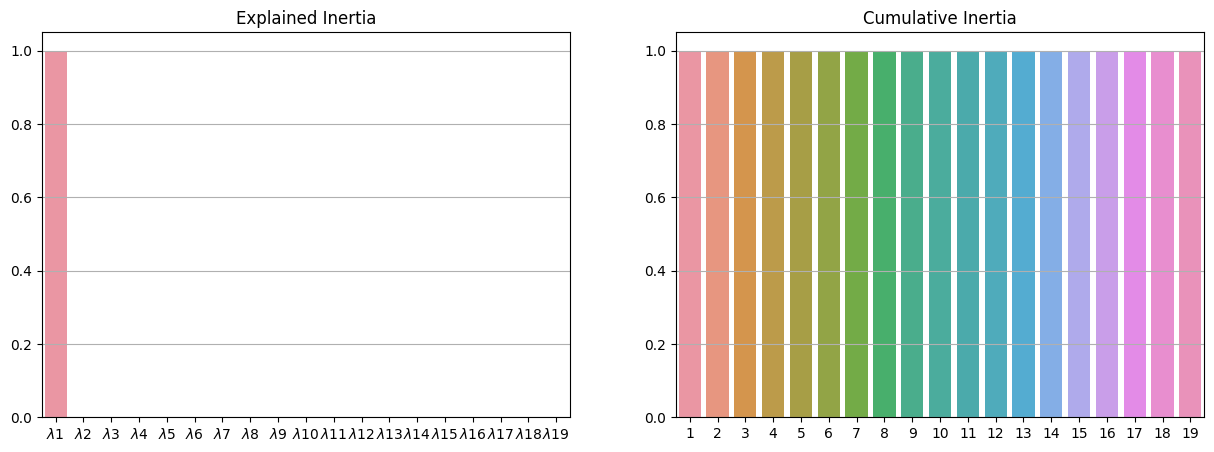

In [361]:
#cascade valeurs propres, vp cummulés
n = len(vpB)
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Explained Inertia")
ax2.set_title("Cumulative Inertia")
ax1.grid()
ax2.grid()
a = sum(vpB)
# Create a bar plot for explained inertia :
x = [f'$\lambda${i}' for i in range(1, n + 1)]
yy = [vpB[i] / a for i in range(n)]
sb.barplot(x=x, y=yy, ax=ax1)
# Create a bar plot for cumulative explained inertia :
x = [f'{i}' for i in range(1, n + 1)]
yy = [sum(vpB[:i + 1]) / a for i in range(n)]
sb.barplot(x=x, y=yy, ax=ax2)

plt.show()

Comme on vient d'évoquer à l'introduction il ne s'agit que d'une seule composante principale significative.

Essayons de créer une fonction projetant les points sur la composante principale.

In [362]:
def transformation(V,B,X)  :
    V_inv = np.linalg.inv(V)
    A=np.dot(V_inv,B)
    valeur_propre,vecteur_propre=np.linalg.eig(A)
    #ordonner les valeurs et vecteurs selon inertie expliquée
    idx=np.argsort(abs(valeur_propre))[::-1]
    valeur_propre=valeur_propre[idx]
    vecteur_propre=vecteur_propre[idx]
    #on visualise à partir du centre de gravité
    #on nous restreint à 2 dim
    X_centre=center(X)
    vecteur_propre=vecteur_propre.real
    X_nv= X_centre.dot(vecteur_propre[:,0])
    return X_nv

Essayons maintenant de visualiser nos données.

In [363]:
X_nv=transformation(V,B,X)
X_nv

0      0.921702
1      0.157616
2     -0.004279
3     -0.386765
4      0.520009
         ...   
604   -0.860919
605   -0.131287
606    0.904913
607    0.436860
608   -0.144881
Length: 609, dtype: float64

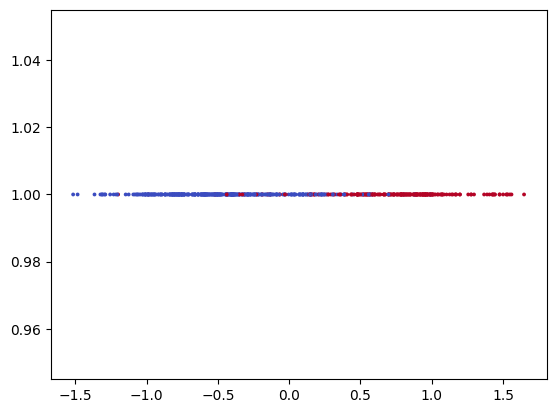

In [364]:
dummy=[1]*len(X_nv)
plt.scatter(X_nv, dummy, c=y, s=3,cmap='coolwarm')
plt.show()
#bleu->"H"
#rouge-> "L"

On constate que notre composante a pu bien séparer les deux classes.

## 6.3 calcul de la qualité de projection sur test

La qualité de projection sur un axe peut être formulée comme suite: $Q_i= \frac{1}{n} \frac{C_i^2}{λ}$, on peut la calucer simplement sans la mise en oeuvre d'un fonction.

In [365]:
test= pd.read_csv("test_data.csv")
test

,Income_Inequality,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
0,H,3118.343699,4013.387617,6584.963632,5,37.131321,145.0,104.9,6.039,0.132618,1.057144e+06,0.671585,1.431295,0.414552,-0.990930,53.875463,0.947583,34.731008,36.60,3.08191
1,H,3185.122401,5360.889146,7766.977359,9,32.000000,145.0,92.9,5.864,0.133924,1.162079e+06,0.622806,1.445598,0.449489,-1.055084,54.933176,1.091497,22.124248,34.53,3.12292
2,H,3100.830685,5508.138454,7991.803167,15,42.000000,145.0,88.3,5.774,0.147570,1.145485e+06,0.426284,1.452803,0.416866,-0.893183,56.056403,1.125185,13.305675,35.25,3.48690
3,H,2914.415459,5285.425544,7088.190165,16,41.813129,145.0,84.4,5.686,0.154190,1.092634e+06,0.243273,1.460044,0.417792,-0.936142,56.904924,1.012552,20.885120,0.00,2.75494
4,H,2808.521753,5462.176989,7059.195320,16,43.013260,121.0,81.1,5.600,0.148656,1.281953e+06,0.316407,1.467321,0.414517,-0.919977,58.013752,0.829723,25.950330,0.00,2.46688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,H,6252.317977,10436.142085,13068.735914,40,85.900002,226.0,38.3,2.424,0.531852,2.631893e+06,0.513804,2.675951,0.602909,0.164873,56.285901,8.191153,4.665734,21.33,5.48978
257,H,1198.304817,2326.664974,3298.703671,11,22.000000,117.0,78.7,5.363,0.171000,2.436316e+05,0.468498,2.222129,0.303489,-0.866416,69.491694,0.192639,18.664720,34.47,3.70000
258,H,1294.500770,2445.265514,3634.345811,13,29.886272,117.0,72.0,5.026,0.194709,2.497093e+05,0.524847,2.385934,0.308105,-0.521591,65.827419,0.278215,12.023595,30.83,4.30000
259,H,1315.250562,2354.389942,3437.395432,23,35.425453,117.0,65.3,4.707,0.186253,2.587091e+05,0.376191,2.561215,0.296417,-0.704611,65.299678,0.316995,11.677213,0.00,3.74792


In [366]:
#transformation
le = preprocessing.LabelEncoder()
yt = le.fit_transform(test["Income_Inequality"])
del test["Income_Inequality"]


In [367]:
Vt,Bt,Wt,_= var(test,yt)
vpp, _= np.linalg.eig(np.linalg.inv(Vt).dot(Bt))
test_nv= transformation(Vt, Bt, test)
n=len(test_nv)
qual= (1/n)*(test_nv**2)*(1/vpp[0].real)

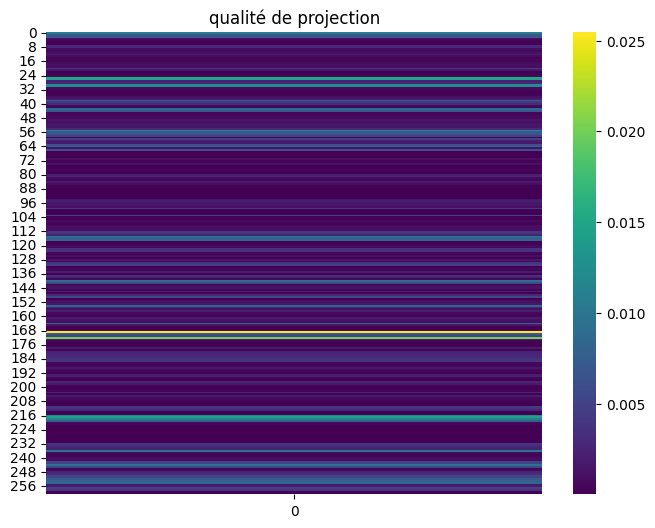

In [368]:
# visualisation
n=len(qual)
plt.figure(figsize=(8, 6))
sb.heatmap(np.array(qual).reshape(n,1), cmap='viridis')
plt.title('qualité de projection')
plt.show()

Retrievons les 10 individus mal projetés

In [369]:
seuil= sorted(qual)[10]
qual[qual<seuil]

100    2.922812e-06
127    1.015699e-07
142    1.671706e-06
147    4.297129e-07
196    1.415196e-07
201    1.722550e-06
210    2.187167e-06
214    1.887586e-06
222    1.263481e-07
260    3.035730e-06
dtype: float64

In [370]:
least_proj

array([ 51,  82,  83,  84, 145, 158, 160, 166, 167, 246])

On constate bien que les mal projtés de l'AFD sont totalement distincts des malprojetés de l'ACP; En effet, il ne faut pas s'attendre à avoir les mêmes résultats car le but primale de l'AFD est de classifier les individus en maximisant l'intervariance entre les groupes, un individu mal projeté dans ce cas est un individu qui est mal classifié. Cependant dans les individus mal projetés par l'ACP indique un individu atypique pour l'ensemble de données, de plus l'ACP n'a rien à faire avec la classification puisq'elle traite le problème de maximisation de variance d'une manière globale et pas discriminative pour chacune des classes comme l'AFD.

# Partie 7: l'AFD prédictive

## 7.1 AFD prédictive sur les données normales

Puisqu'on est dans le cas de classes binaires, le score de Fisher est le plus adapté , il est défini comme la difference entre la distance des deux classes: $f(x)= (x-μ_H)^{T}W^{-1}(x-μ_H) - (x-μ_L)^{T}W^{-1}(x-μ_L)$.

Si f(x)>0 alors l'individu sera classifié dans L.

In [371]:
mH= np.array(np.mean(X[y==0], axis=0))
mL= np.array(np.mean(X[y==1], axis=0))
_,p= X.shape

In [372]:
def fischer(x):
  a= (np.array(x)-mH).reshape(1,p)
  b= (np.array(x)-mL).reshape(1,p)
  v1= np.dot(np.dot(a,np.linalg.inv(W)),a.T)
  v2= np.dot(np.dot(b,np.linalg.inv(W)),b.T)
  if all((v1-v2)>0):
    return 1
  return 0

In [373]:
Y= pd.read_csv("test_data.csv")
Y.head()

,Income_Inequality,Eco1,Eco2,Eco3,Energy1,Energy2,Energy3,Health1,Health2,Finan1,Finan2,Finan3,Finan4,Finan5,Governance,Poverty,Env,Other1,Other2,Other3
0,H,3118.343699,4013.387617,6584.963632,5,37.131321,145.0,104.9,6.039,0.132618,1057144.125,0.671585,1.431295,0.414552,-0.990930,53.875463,0.947583,34.731008,36.60,3.08191
1,H,3185.122401,5360.889146,7766.977359,9,32.000000,145.0,92.9,5.864,0.133924,1162079.125,0.622806,1.445598,0.449489,-1.055084,54.933176,1.091497,22.124248,34.53,3.12292
2,H,3100.830685,5508.138454,7991.803167,15,42.000000,145.0,88.3,5.774,0.147570,1145485.375,0.426284,1.452803,0.416866,-0.893183,56.056403,1.125185,13.305675,35.25,3.48690
3,H,2914.415459,5285.425544,7088.190165,16,41.813129,145.0,84.4,5.686,0.154190,1092634.500,0.243273,1.460044,0.417792,-0.936142,56.904924,1.012552,20.885120,0.00,2.75494
4,H,2808.521753,5462.176989,7059.195320,16,43.013260,121.0,81.1,5.600,0.148656,1281953.250,0.316407,1.467321,0.414517,-0.919977,58.013752,0.829723,25.950330,0.00,2.46688


In [374]:
#on encode H==0 et L==1 dans y_test
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(Y["Income_Inequality"])
del Y["Income_Inequality"]

Maintenant on classifie nos données test dans y_fischer en assignant 0 pour la classe "H" et 1 pour la classe "L".

In [375]:
y_fischer=[]
n,_=Y.shape
for i in range(n):
  y_fischer.append(fischer(np.array(Y.iloc[i])))

Claculons l'erreur de classification.

In [376]:
np.sum(y_test!=y_fischer)/n

0.13409961685823754

Ainsi notre modèle construit des données train a bien pu classifié nos données test avec une précision presque égale à 86%.

In [377]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test ,y_fischer)
cm

array([[146,  22],
       [ 13,  80]])

In [378]:
sp= cm[1,1]/np.sum(cm[:,1])
se= cm[0,0]/np.sum(cm[:,0])
print("sensibilité :", se*100, "%")
print("spécificité :", sp*100, "%")

sensibilité : 91.82389937106919 %
spécificité : 78.43137254901961 %


Ce modèle a bien pu discerner les individus positives (inégalité de revenus basse) que les individus négatifs (haute inégalité de revenus).

## 7.2 AFD prédictive sur les données standardisés

Importons nos données normalisés.

In [379]:
Yn= pd.DataFrame(cennor(Y.values))
Yn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.659986,-0.946097,-0.832418,-1.855067,-1.718766,1.181314,2.161869,2.315467,-1.059883,-0.314672,0.223286,-1.753838,-1.010875,-1.236816,1.318840,-0.834187,4.893303,1.362849,-1.012496
1,-0.656493,-0.836759,-0.763816,-1.695419,-1.907612,1.181314,1.818004,2.193360,-1.054652,-0.305397,0.052555,-1.734263,-0.854923,-1.304182,1.372409,-0.798829,2.835554,1.230394,-0.986028
2,-0.660902,-0.824811,-0.750767,-1.455947,-1.539586,1.181314,1.686189,2.130562,-0.999984,-0.306864,-0.635287,-1.724403,-1.000548,-1.134176,1.429295,-0.790552,1.396135,1.276466,-0.751113
3,-0.670652,-0.842882,-0.803211,-1.416035,-1.546464,1.181314,1.574433,2.069160,-0.973466,-0.311535,-1.275842,-1.714493,-0.996413,-1.179286,1.472269,-0.818225,2.633296,-0.979108,-1.223525
4,-0.676191,-0.828540,-0.804894,-1.416035,-1.502296,0.677463,1.479870,2.009153,-0.995633,-0.294802,-1.019866,-1.704534,-1.011030,-1.162312,1.528427,-0.863145,3.460069,-0.979108,-1.409440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,-0.496059,-0.424947,-0.456111,-0.458147,0.076047,2.881810,0.253419,-0.206918,0.539454,-0.175482,-0.328962,-0.050439,-0.170078,-0.023151,1.440919,0.945514,-0.014127,0.385754,0.541559
257,-0.760416,-1.082959,-1.023147,-1.615595,-2.275638,0.593488,1.411097,1.843785,-0.906122,-0.386577,-0.487535,-0.671527,-1.506646,-1.106069,2.109738,-1.019673,2.270869,1.226555,-0.613577
258,-0.755384,-1.073336,-1.003667,-1.535771,-1.985403,0.593488,1.219106,1.608641,-0.811143,-0.386040,-0.290309,-0.447348,-1.486041,-0.743981,1.924157,-0.998647,1.186866,0.993639,-0.226333
259,-0.754299,-1.080710,-1.015097,-1.136651,-1.781547,0.593488,1.027115,1.386057,-0.845021,-0.385245,-0.810619,-0.207464,-1.538213,-0.936163,1.897429,-0.989119,1.130327,-0.979108,-0.582649


Définissons les moyennes, l'intra-variance normalisé et la fonction fischer_normal pour classifier.

In [380]:
mnL= np.array(np.mean(Yn[y_test==1], axis=0))
mnH= np.array(np.mean(Yn[y_test==0], axis=0))
Wn= var(pd.DataFrame(Yn),y_test)[2]
def fischer_normal(x):
  a= (np.array(x)-mnH).reshape(1,p)
  b= (np.array(x)-mnL).reshape(1,p)
  v1= np.dot(np.dot(a,np.linalg.inv(Wn)),a.T)
  v2= np.dot(np.dot(b,np.linalg.inv(Wn)),b.T)
  if all((v1-v2)>0):
    return 1
  return 0

In [381]:
y_fischer_norm=[]
for i in range(n):
  y_fischer_norm.append(fischer_normal(np.array(Yn.iloc[i])))

In [382]:
np.sum(y_fischer_norm!=y_test)/n

0.10344827586206896

Le classifieur normé a achevé une précision de 90%, mieux que le classifieur précedent. Calculons sa matrice de confusion.

In [383]:
from sklearn.metrics import confusion_matrix
cmn = confusion_matrix(y_test ,y_fischer_norm)
cmn

array([[151,  17],
       [ 10,  83]])

In [384]:
spn= cmn[1,1]/np.sum(cmn[:,1])
sen= cmn[0,0]/np.sum(cmn[:,0])
print("sensibilité :", sen*100, "%")
print("spécificité :", spn*100, "%")

sensibilité : 93.7888198757764 %
spécificité : 83.0 %


La capacité de distinguer les deux classes a aussi amelioré.

# Conclusion

Dans ce TP on a étudié des méthodes de classification supervisés (**AFD & arbres**) ainsi que des méthodes de maximisation de variance et réduction des dimensions des données (**ACP**). Nous avons surtout bien pu distinguer l'importance de la normalisation dans transformation de la base de données à variables dont les échelles de représentation sont trop variés entre eux, surtout dans la distinction entre les anomalies. Parlant des anomalies, une grande partie de ce TP a été concentré sur des algorithmes de leurs détection: on est partit des forêts d'isolement, puis on a évalué la capacité de l'ACP à les discerner à partir des individus faiblement projetés sur les axes principaux, puis on a utilisé un algorithme d'ACP inverse qui a été plus performant que le dernier.

Néaumoins les algorithme de type Black-Box tel que la forêt d'isolement reste le plus performant en perspective de la détection des anomalies.

Enfin, il faut bien noter que dans l'AFD le discriminant utilisé peut être amelioré de telle façon qu'il peuve prendre en compte le taux de représentation de la classe et leurs dispersions depuis leurs centroides... Mais de telle critère s'avèrent innécessaires pour en prendre compte puisqu'on est mis dans le cas d'une classification binaire.